In [1]:
import pandas as pd
import numpy as np
from gammapy.data import DataStore
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

import astropy.units as u
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time

from gammapy.data import DataStore
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import Background2D, Background3D
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis,WcsNDMap, WcsGeom

from copy import deepcopy

from regions import CircleSkyRegion, CircleAnnulusSkyRegion


# Select runs

In [2]:
grb_table = pd.read_csv('grb.txt')

In [3]:
datastore = DataStore.from_dir("/raid/romulus/dl3/ed/dl3_fullenclosure_moderate2tel/")

In [4]:
obs_table = datastore.obs_table

In [5]:
obs_table

OBS_ID,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,N_TELS,TELLIST,OBJECT,RA_OBJ,DEC_OBJ,DATE-OBS,DATE-AVG,DATE-END,NSBLEVEL
,deg,deg,deg,deg,deg,s,s,,s,s,,,,deg,deg,,,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20,bytes20,float32,float32,bytes20,bytes20,bytes20,float32
100000,83.63455,21.514473,11.213523,78.786476,207.0248,841.0,704.42957,0.83760947,526564770.0,526565630.0,4,"T1,T2,T3,T4",Crab,83.63333,22.014471,2021-10-09T11:59:33.,2021-10-09T12:06:33.,2021-10-09T12:13:33.,7.7918477
100002,-61.190514,65.146095,33.716835,56.283165,357.7856,57.0,41.639854,0.73052377,526615940.0,526615970.0,4,"T1,T2,T3,T4",1ES1959+650,299.99915,65.14863,2021-10-10T02:12:01.,2021-10-10T02:12:29.,2021-10-10T02:12:58.,8.3054285
100003,-61.190514,65.146095,33.64939,56.35061,355.32874,1081.0,876.13116,0.81048214,526616220.0,526617440.0,4,"T1,T2,T3,T4",1ES1959+650,299.99915,65.14863,2021-10-10T02:17:14.,2021-10-10T02:27:14.,2021-10-10T02:37:15.,8.049949
100004,-73.735725,6.8660345,34.413235,55.586765,229.25314,1795.0,1467.8853,0.8177634,526617660.0,526619460.0,4,"T1,T2,T3,T4",MGRO J1908+06 centro,286.97504,6.1579785,2021-10-10T02:40:43.,2021-10-10T02:55:44.,2021-10-10T03:10:44.,8.164385
100005,-10.53377,29.141014,24.915157,65.08484,88.2559,1801.0,1547.4976,0.8592435,526619740.0,526621570.0,4,"T1,T2,T3,T4",2FHL J2317.8+2838,349.46597,28.641014,2021-10-10T03:15:52.,2021-10-10T03:30:52.,2021-10-10T03:45:52.,7.0306883
100006,-10.5342655,28.141014,18.560398,71.439606,95.51992,1801.0,1554.339,0.8630422,526621600.0,526623400.0,4,"T1,T2,T3,T4",2FHL J2317.8+2838,349.46597,28.641014,2021-10-10T03:46:25.,2021-10-10T04:01:25.,2021-10-10T04:16:25.,6.8576965
100007,-9.964314,28.639605,12.374892,77.62511,100.97679,1801.0,1539.2765,0.85467875,526623420.0,526625200.0,4,"T1,T2,T3,T4",2FHL J2317.8+2838,349.46597,28.641014,2021-10-10T04:17:05.,2021-10-10T04:32:05.,2021-10-10T04:47:05.,6.791364
100008,-9.150593,58.314976,27.076231,62.923767,7.290189,1801.0,1554.0616,0.8628882,526625400.0,526627200.0,4,"T1,T2,T3,T4",Cas A,350.85,58.814976,2021-10-10T04:49:51.,2021-10-10T05:04:51.,2021-10-10T05:19:51.,7.3118277


In [6]:
obs_table = obs_table.to_pandas()

In [7]:
grouped = obs_table.groupby(['OBJECT'])['LIVETIME'].agg('sum')/60
grouped = grouped.sort_values()

In [8]:
pd.set_option('display.max_rows', 500)

np.set_printoptions(threshold=2000)
grouped.tail(50)

OBJECT
b'RBS 1366'                 3789.729980
b'CTB109'                   3823.504883
b'ngc 1275'                 3875.759521
b'PKS 1222+216'             3925.771729
b'RBS 0413'                 3935.174561
b'1ES0502+675'              4109.585938
b'PSR J2238+5903'           4430.077637
b'Geminga'                  4603.256836
b'1ES1011+496'              4646.014648
b'1ES0647+250'              4788.253418
b'Cas A'                    4850.192383
b'CTA 1'                    5043.204590
b'1ES1440+122'              5050.449707
b'1ES1959+650'              5107.515625
b'S5 0716+714'              5140.939941
b'1ES0033+595'              5320.630371
b'Draco'                    5722.720703
b'3C 264'                   6092.825195
b'3C 120'                   6399.284180
b'1ES0806+524'              6502.157715
b'RGB J0509+056'            6926.138672
b'1ES2344+514'              6975.860352
b'VER J0521+211'            7263.265137
b'OJ 287'                   7311.365723
b'BL Lac'                   8616.

In [9]:
# filter out extended and strong sources and get write out runlist
drop_list= [b'Crab', b'Mrk421', b'Mrk501',b'MGRO J1908+06 centro',b'Boomerang',b'Sgr A*',b'Sgr A* Off',b'IC443 Hot Spot',b'Gamma Cygni',b'M31',b'LS I +61 303',b'VER J0521+211']

filtered = grouped.drop(drop_list)
#table_gtf = table_gtf.drop(VPM_runs)

filtered[-10:]

OBJECT
b'Ursa Major II'      11673.243164
b'Tycho'              11989.428711
b'PG1553+113'         12601.603516
b'1ES0229+200'        13041.795898
b'3C273'              13129.497070
b'1ES1218+304'        13826.311523
b'PKS 1424+240'       14037.645508
b'HESS J0632 +057'    15845.305664
b'M82'                17821.197266
b'M87'                21189.351562
Name: LIVETIME, dtype: float32

In [10]:
filtered.index

Index([         b'GRB120403A',  b'CALIPSO-2022-04-07', b'ICESAT-2-2023-12-13',
        b'CALIPSO-2022-09-26', b'ICESAT-2-2023-10-11',  b'CALIPSO-2021-06-14',
         b'GRB090428 INITIAL',    b'BSC 4.89 Tau 47A',          b'GRB101207A',
          b'UCAC4 429-072213',
       ...
             b'Ursa Major II',               b'Tycho',          b'PG1553+113',
               b'1ES0229+200',               b'3C273',         b'1ES1218+304',
              b'PKS 1424+240',     b'HESS J0632 +057',                 b'M82',
                       b'M87'],
      dtype='object', name='OBJECT', length=1372)

In [11]:
runlist = obs_table[obs_table['OBJECT'].isin(filtered.index)]
runlist['LIVETIME'].sum() / 60

680895.6666666666

In [12]:
runlist = runlist[~runlist['OBS_ID'].isin(grb_table[' Run'])]

In [13]:
runlist

,OBS_ID,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,N_TELS,TELLIST,OBJECT,RA_OBJ,DEC_OBJ,DATE-OBS,DATE-AVG,DATE-END,NSBLEVEL
1,100002,-61.190514,65.146095,33.716835,56.283165,357.785614,57.0,41.639854,0.730524,526615936.0,526615968.0,4,"b'T1,T2,T3,T4'",b'1ES1959+650',299.999146,65.148628,b'2021-10-10T02:12:01.',b'2021-10-10T02:12:29.',b'2021-10-10T02:12:58.',8.305429
2,100003,-61.190514,65.146095,33.649391,56.350609,355.328735,1081.0,876.131165,0.810482,526616224.0,526617440.0,4,"b'T1,T2,T3,T4'",b'1ES1959+650',299.999146,65.148628,b'2021-10-10T02:17:14.',b'2021-10-10T02:27:14.',b'2021-10-10T02:37:15.',8.049949
4,100005,-10.533770,29.141014,24.915157,65.084839,88.255898,1801.0,1547.497559,0.859244,526619744.0,526621568.0,4,"b'T1,T2,T3,T4'",b'2FHL J2317.8+2838',349.465973,28.641014,b'2021-10-10T03:15:52.',b'2021-10-10T03:30:52.',b'2021-10-10T03:45:52.',7.030688
5,100006,-10.534266,28.141014,18.560398,71.439606,95.519920,1801.0,1554.338989,0.863042,526621600.0,526623392.0,4,"b'T1,T2,T3,T4'",b'2FHL J2317.8+2838',349.465973,28.641014,b'2021-10-10T03:46:25.',b'2021-10-10T04:01:25.',b'2021-10-10T04:16:25.',6.857697
6,100007,-9.964314,28.639605,12.374892,77.625107,100.976791,1801.0,1539.276489,0.854679,526623424.0,526625216.0,4,"b'T1,T2,T3,T4'",b'2FHL J2317.8+2838',349.465973,28.641014,b'2021-10-10T04:17:05.',b'2021-10-10T04:32:05.',b'2021-10-10T04:47:05.',6.791364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41167,99375,67.810127,56.889324,25.783276,64.216728,9.605306,1681.0,1452.968262,0.864348,526557408.0,526559072.0,4,"b'T1,T2,T3,T4'",b'SNR G150.3+4.5 P1',67.810127,56.889324,b'2021-10-09T09:56:29.',b'2021-10-09T10:10:29.',b'2021-10-09T10:24:29.',7.042915
41168,99376,117.848938,2.592691,56.304241,33.695759,110.123756,361.0,306.536987,0.849133,526559584.0,526559936.0,4,"b'T1,T2,T3,T4'",b'UCAC4 463-038355',117.848938,2.592691,b'2021-10-09T10:33:00.',b'2021-10-09T10:36:00.',b'2021-10-09T10:39:00.',8.083602
41169,99377,67.810127,56.889324,25.386398,64.613602,355.337280,1681.0,1433.765503,0.852924,526560128.0,526561824.0,4,"b'T1,T2,T3,T4'",b'SNR G150.3+4.5 P1',67.810127,56.889324,b'2021-10-09T10:42:04.',b'2021-10-09T10:56:04.',b'2021-10-09T11:10:04.',7.015393
41170,99378,75.310089,56.889324,25.375462,64.624535,355.374237,1681.0,1454.922119,0.865510,526561920.0,526563616.0,4,"b'T1,T2,T3,T4'",b'SNR G150.3+4.5 P1 OF',75.310089,56.889324,b'2021-10-09T11:12:03.',b'2021-10-09T11:26:03.',b'2021-10-09T11:40:03.',6.818281


# Set up directories

In [14]:
base_dir = '/raid/romulus/swong/backgrounds/'
bins = ['V6_moderate2tel_az-9090_ze0010',
        'V6_moderate2tel_az-9090_ze1020',
        'V6_moderate2tel_az-9090_ze2030',
        'V6_moderate2tel_az-9090_ze3040',
        'V6_moderate2tel_az-9090_ze4045',
        'V6_moderate2tel_az-9090_ze4550',
        'V6_moderate2tel_az-9090_ze5055',
        'V6_moderate2tel_az-9090_ze5560',
        'V6_moderate2tel_az90270_ze0010',
        'V6_moderate2tel_az90270_ze1020',
        'V6_moderate2tel_az90270_ze2030',
        'V6_moderate2tel_az90270_ze3040',
        'V6_moderate2tel_az90270_ze4045',
        'V6_moderate2tel_az90270_ze4550',
        'V6_moderate2tel_az90270_ze5055',
        'V6_moderate2tel_az90270_ze5560',
       ]

In [15]:
def load_exclusion_regions(exclusion_file='VTSCat.csv'):
    """
        Calculate a radial acceptance map

        Parameters
        ----------
        exclusion_file : Path to csv file with coordinates of sources in RA/DEC

        Returns
        -------
        exclusion_regions_vts : list of regions.shapes.circle.CircleSkyRegion
            A list of exclusion regions
    """

    # load VTSCat "catalog"
    VTSCat = pd.read_csv(exclusion_file)
    VTSCat.rename(columns={'pos_ra': 'RA', 'pos_dec': 'DEC', 'common_name': 'Source_Name'}, inplace=True)
    VTSCat[['RA', 'DEC']]
    VTSCat = VTSCat.loc[VTSCat['source_id'] < 100000]  ### only detected sources
    VTSCat['position'] = SkyCoord(VTSCat['RA'], VTSCat['DEC'], unit="deg", frame="icrs")
    ## VTS Cat generated exclusion regions with 0.3° radius, currently 84 known sources
    exclusion_radius = Angle("0.3 deg")
    exclusion_regions_vts = [(VTSCat['RA'][i],VTSCat['DEC'][i], exclusion_radius.value) for i in range(len(VTSCat))]
    return exclusion_regions_vts

In [16]:
exclusion_regions = load_exclusion_regions('./VTSCat.csv')
#exclusion_regions

In [17]:
class BackgroundModelEstimator:
    
    def __init__(self,
        energy, 
        offset,
        excluded_sources,
        smooth,
        smooth_sigma: float = 1,):

        self.excluded_sources = excluded_sources
        self.smooth = smooth
        self.smooth_sigma = smooth_sigma
        self.counts = self._make_bkg2d(energy, offset, unit="")
        self.exposure = self._make_bkg2d(energy, offset, unit="s TeV sr")
        #self.exclusion = ExclusionFinder()
    @staticmethod
    def _make_bkg2d(energy, offset, unit):
        return Background2D(axes=[energy, offset], unit=unit)

    def run(self, observations):
        for obs in observations:
            counts, exposure = self.fill_counts(obs)
            self.counts.data += counts
            self.exposure.quantity += exposure

    def fill_counts(self, obs):
        energy, offset = self.counts.axes
        run_ra = obs.pointing.fixed_icrs.ra.deg
        run_dec = obs.pointing.fixed_icrs.dec.deg
        events = obs.events
        events.table['offset'] = events.offset.to("deg")
        #display(events.table)

        events = MapDatasetEventSampler.event_det_coords(obs, events)
        run_mask = np.ones(len(events.table), dtype=bool)
        for reg in self.excluded_sources:
            run_mask &= ((events.table["RA"] - reg[0]) ** 2 + (events.table["DEC"] - reg[1]) ** 2) > reg[2] ** 2
        counts = np.histogram2d(
            events.energy[~run_mask].to('TeV'), events.offset.to("deg")[~run_mask],
            (energy.edges, offset.edges))[0]  
        self.counts.data += counts
        counts_all = np.histogram(events.offset.to("deg"), bins=offset.edges)[0] + 1e-9
        # Only kept events
        counts_exc = (
            np.histogram(events.offset[~run_mask].to("deg"), bins=offset.edges)[0] + 1e-9
        )

        axes = self.exposure.axes
        offset = axes["offset"].center
        time = obs.observation_time_duration
        exposure = 2 * np.pi * offset * time * axes.bin_volume()

        # Scale exposure by fraction of events accepted
        # self.exposure.quantity += exposure * (counts_exc / counts_all)
        return counts, exposure * (counts_exc / counts_all)

    @property
    def background_rate(self):
        rate = deepcopy(self.counts)
        rate.quantity /= self.exposure.quantity
        if self.smooth:
            #rate = smooth(rate, sigma=self.smooth_sigma)
            rate = poly_smooth(rate)
        return rate

def smooth(bkg: Background2D, sigma: float = 1.0) -> Background2D:
    bkg_3d = bkg.to_3d()
    for i in range(len(bkg_3d.data)):
        smoothed = gaussian_filter(bkg_3d.data[i, :, :], sigma, 0)
        bkg_3d.data[i, :, :] = smoothed
    return bkg_3d.to_2d

def poly_smooth(bkg):
    offset = bkg.axes['offset'].center.value
    for i in range(len(bkg.data)):
        poly = np.polyfit(offset,bkg.data[i,:],deg=5)
        p = np.poly1d(poly)
        bkg.data[i,:] = p(offset)
    return bkg

In [30]:
emin = 0.01
emax = 100
ebins = 10

energy = MapAxis.from_energy_bounds(
    emin*u.TeV,
    emax*u.TeV,
    ebins,
    name="energy",
    unit="TeV",
)

offset = MapAxis.from_bounds(
    0*u.deg,
    2.5*u.deg,
    nbin=25,
    interp="lin",
    unit="deg",
    name="offset",
)

In [31]:
estimator = BackgroundModelEstimator(
                energy,
                offset,
                smooth=True,
                smooth_sigma=1,
                excluded_sources=exclusion_regions
            )

In [32]:
# get bin-by-bin observations

zeniths = [(0,10),(10,20),(20,30),(30,40),(40,45),(45,50),(50,55),(55,60)]
azimuths = [(-90,90),(90,270)]

epochs = {
        "V4": {"tstart": Time("2000-01-01"), "tstop": Time("2009-09-13")},
        "V5": {"tstart": Time("2009-09-14"), "tstop": Time("2012-07-31")},
        "V6_2012_2013a": {"tstart": Time("2012-08-01"), "tstop": Time("2013-03-15")},
        "V6_2012_2013b": {"tstart": Time("2013-03-16"), "tstop": Time("2013-11-16")},
        "V6_2013_2014a": {"tstart": Time("2013-11-17"), "tstop": Time("2014-05-12")},
        "V6_2013_2014b": {"tstart": Time("2014-05-13"), "tstop": Time("2014-11-07")},
        "V6_2014_2015": {"tstart": Time("2014-11-08"), "tstop": Time("2015-07-31")},
        "V6_2015_2016": {"tstart": Time("2015-08-01"), "tstop": Time("2016-07-31")},
        "V6_2016_2017": {"tstart": Time("2016-08-01"), "tstop": Time("2017-07-31")},
        "V6_2017_2018": {"tstart": Time("2017-08-01"), "tstop": Time("2018-07-31")},
        "V6_2018_2019": {"tstart": Time("2018-08-01"), "tstop": Time("2019-11-12")},
        "V6_2019_2020w": {"tstart": Time("2019-11-13"), "tstop": Time("2020-05-07")},
        "V6_2020_2020s": {"tstart": Time("2020-05-08"), "tstop": Time("2020-11-04")},
        "V6_2020_2021w": {"tstart": Time("2020-11-05"), "tstop": Time("2021-04-27")},
        "V6_2021_2021s": {"tstart": Time("2021-04-28"), "tstop": Time("2021-11-16")},
        "V6_2021_2022w": {"tstart": Time("2021-11-17"), "tstop": Time("2022-05-09")},
        #  "V6_2022_2022s" : {"tstart"  :Time("2022-05-10"), "tstop" : Time("2022-11-08")},
        "V6_2022_2022s": {"tstart": Time("2022-05-10"), "tstop": Time("2025-11-08")},
    }

#estimator.run(observations)

  0%|                                                                                                      | 0/17 [00:00<?, ?it/s]

(0, 10) (-90, 90)


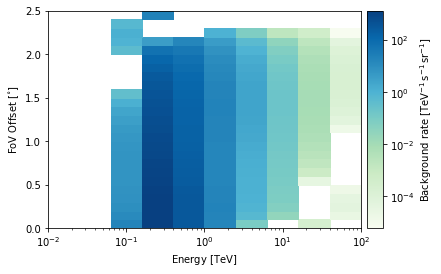

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V4.fits
(10, 20) (-90, 90)


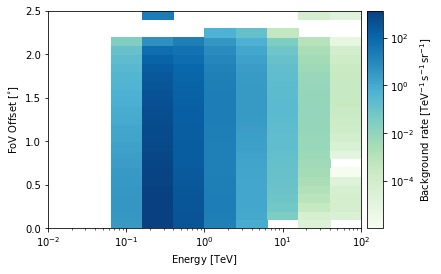

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V4.fits
(20, 30) (-90, 90)


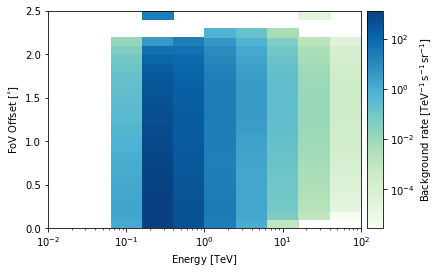

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V4.fits
(30, 40) (-90, 90)


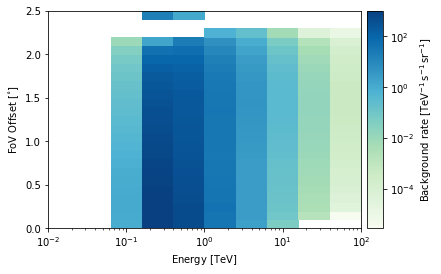

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V4.fits
(40, 45) (-90, 90)


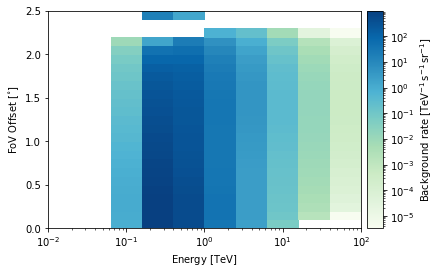

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V4.fits
(45, 50) (-90, 90)


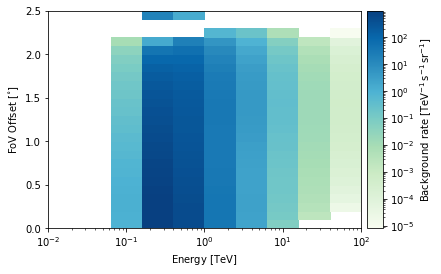

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V4.fits
(50, 55) (-90, 90)


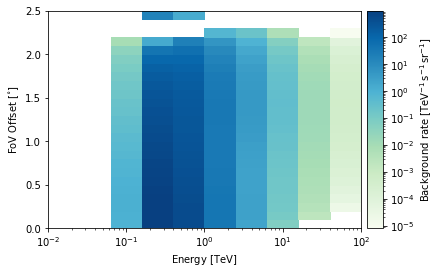

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V4.fits
(55, 60) (-90, 90)


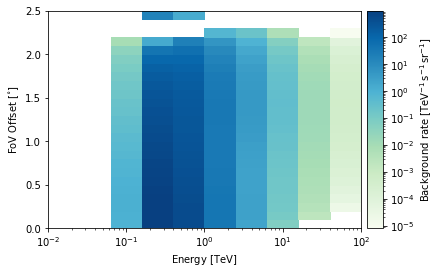

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V4.fits
(0, 10) (90, 270)


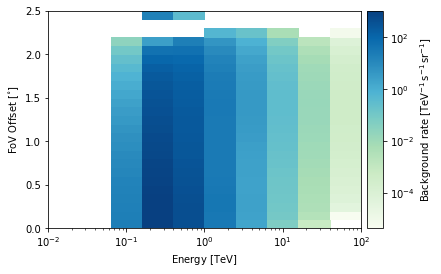

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V4.fits
(10, 20) (90, 270)


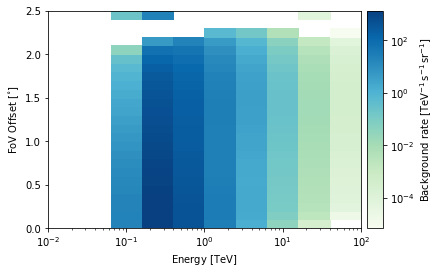

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V4.fits
(20, 30) (90, 270)


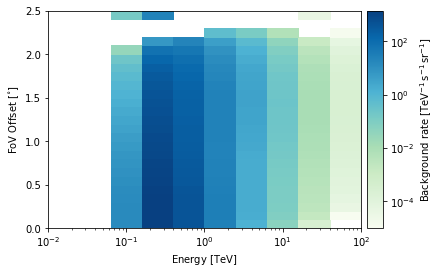

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V4.fits
(30, 40) (90, 270)


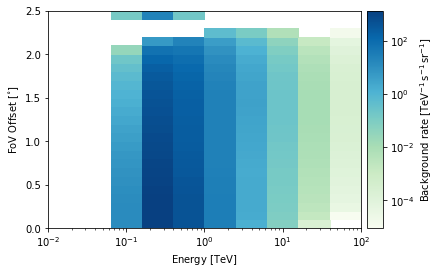

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V4.fits
(40, 45) (90, 270)


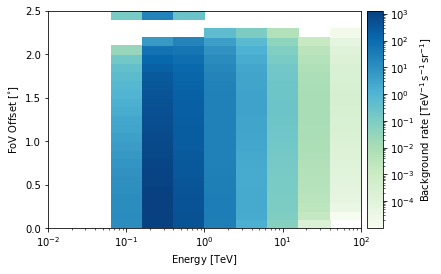

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V4.fits
(45, 50) (90, 270)


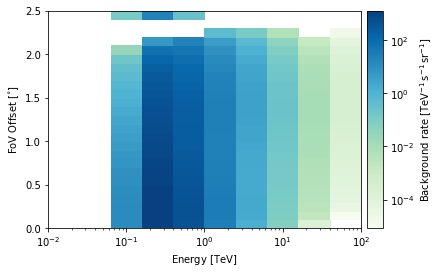

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V4.fits
(50, 55) (90, 270)


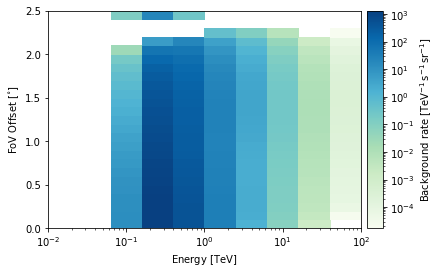

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V4.fits
(55, 60) (90, 270)


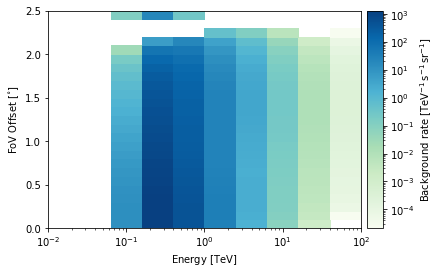

  6%|█████▍                                                                                       | 1/17 [03:35<57:27, 215.45s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V4.fits
(0, 10) (-90, 90)


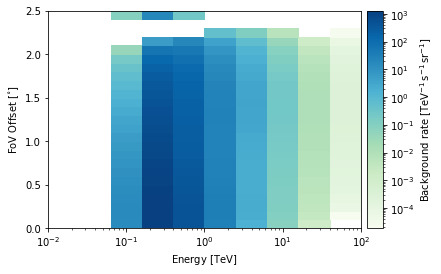

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V5.fits
(10, 20) (-90, 90)


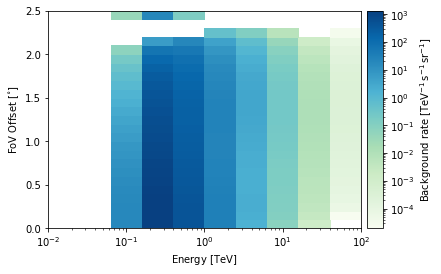

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V5.fits
(20, 30) (-90, 90)


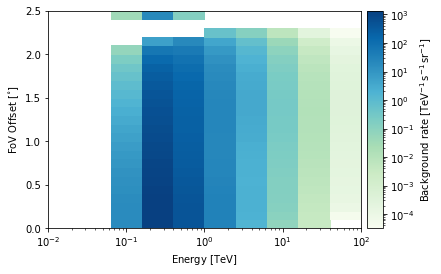

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V5.fits
(30, 40) (-90, 90)


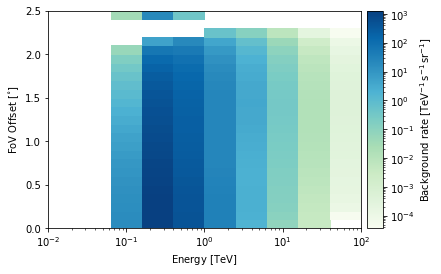

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V5.fits
(40, 45) (-90, 90)


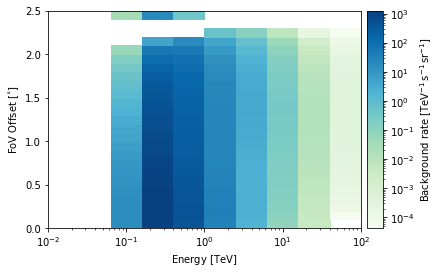

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V5.fits
(45, 50) (-90, 90)


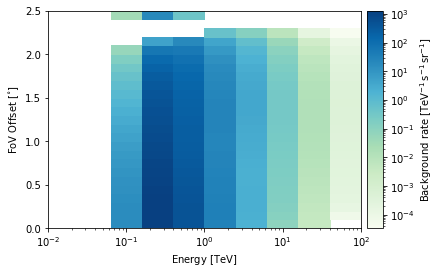

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V5.fits
(50, 55) (-90, 90)


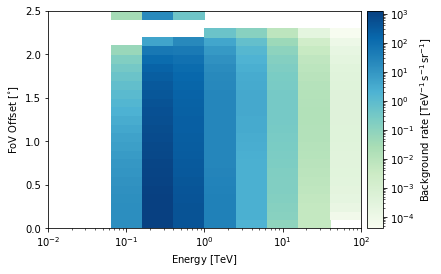

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V5.fits
(55, 60) (-90, 90)


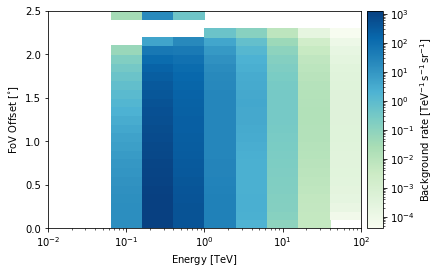

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V5.fits
(0, 10) (90, 270)


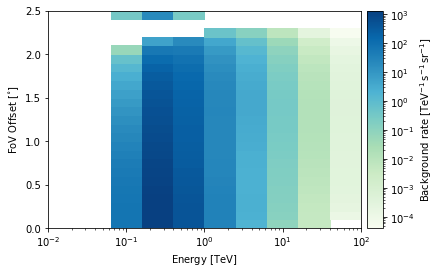

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V5.fits
(10, 20) (90, 270)


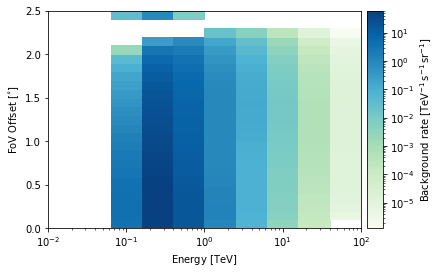

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V5.fits
(20, 30) (90, 270)


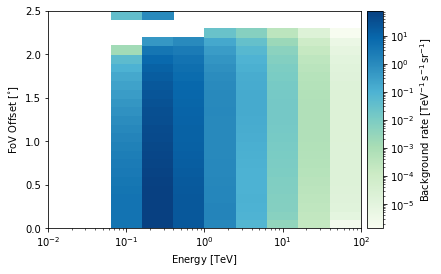

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V5.fits
(30, 40) (90, 270)


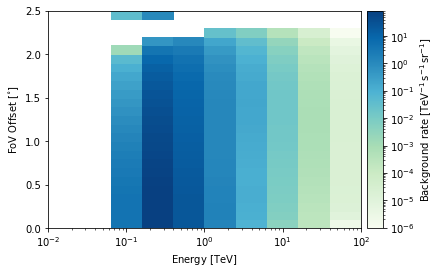

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V5.fits
(40, 45) (90, 270)


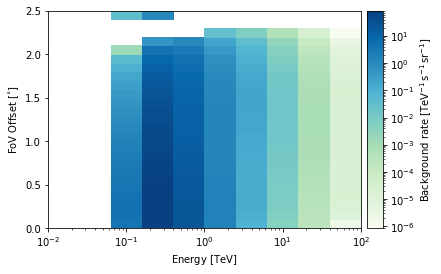

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V5.fits
(45, 50) (90, 270)


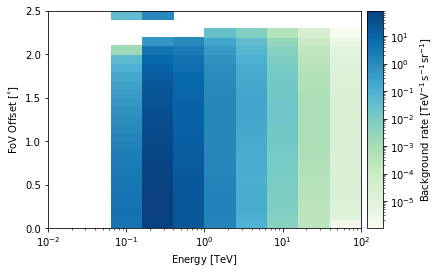

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V5.fits
(50, 55) (90, 270)


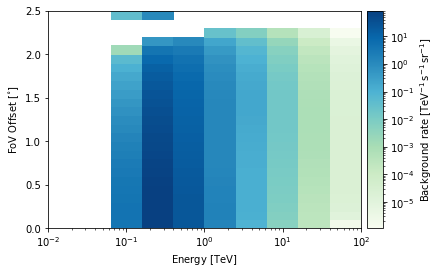

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V5.fits
(55, 60) (90, 270)


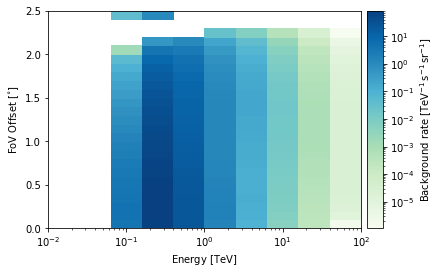

 12%|██████████▋                                                                                | 2/17 [08:43<1:07:24, 269.66s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V5.fits
(0, 10) (-90, 90)


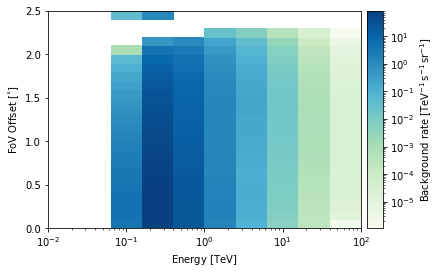

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2012_2013a.fits
(10, 20) (-90, 90)


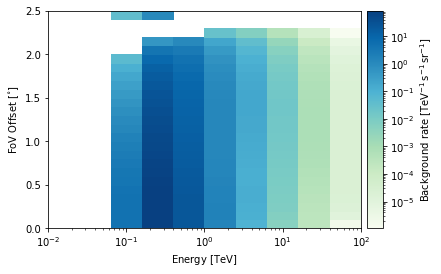

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2012_2013a.fits
(20, 30) (-90, 90)


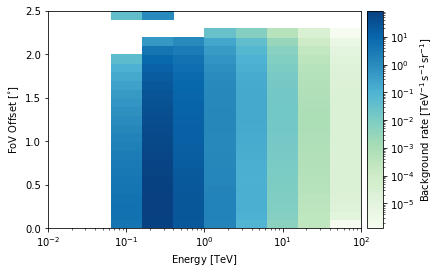

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2012_2013a.fits
(30, 40) (-90, 90)


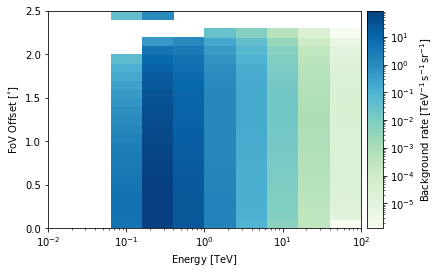

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2012_2013a.fits
(40, 45) (-90, 90)


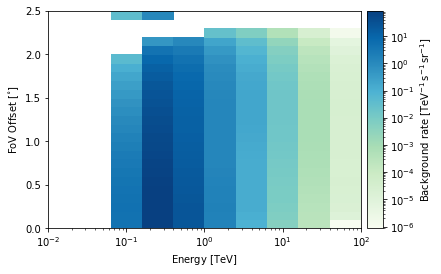

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2012_2013a.fits
(45, 50) (-90, 90)


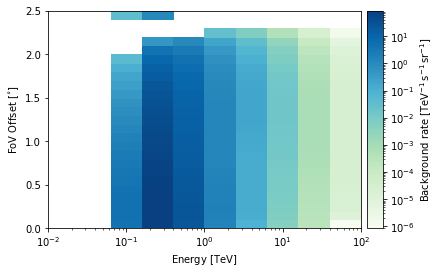

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2012_2013a.fits
(50, 55) (-90, 90)


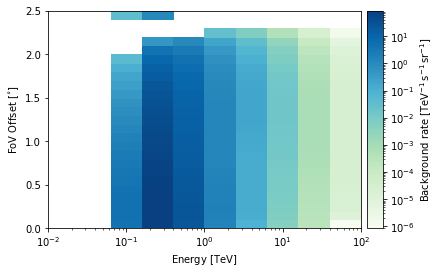

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2012_2013a.fits
(55, 60) (-90, 90)


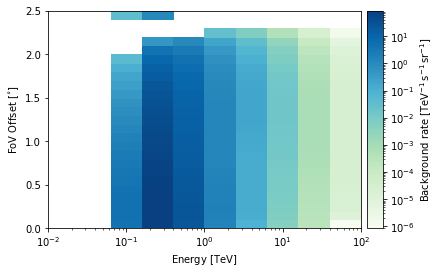

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2012_2013a.fits
(0, 10) (90, 270)


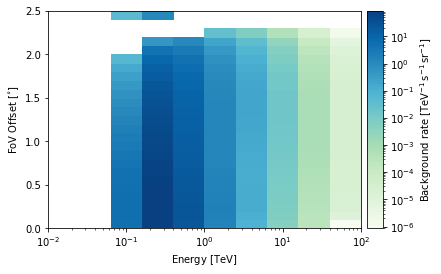

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2012_2013a.fits
(10, 20) (90, 270)


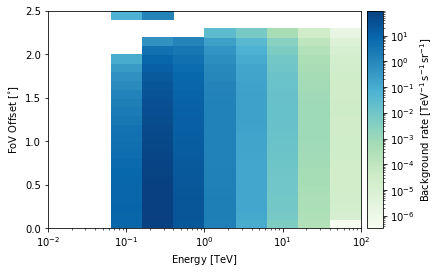

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2012_2013a.fits
(20, 30) (90, 270)


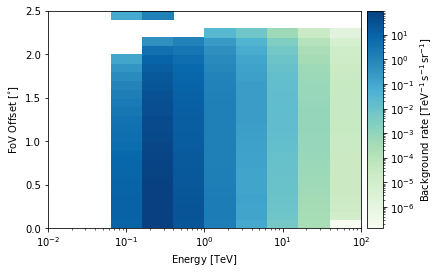

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2012_2013a.fits
(30, 40) (90, 270)


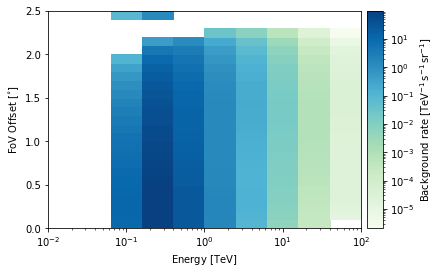

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2012_2013a.fits
(40, 45) (90, 270)


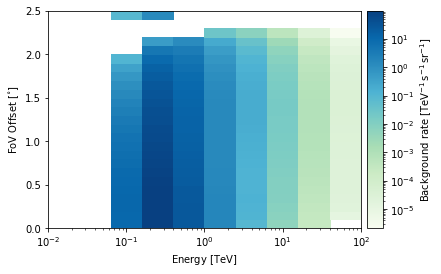

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2012_2013a.fits
(45, 50) (90, 270)


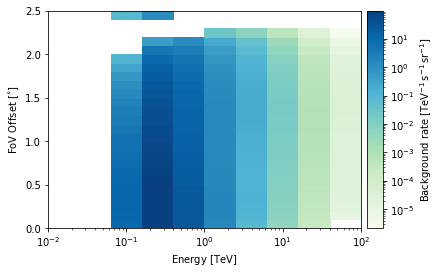

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2012_2013a.fits
(50, 55) (90, 270)


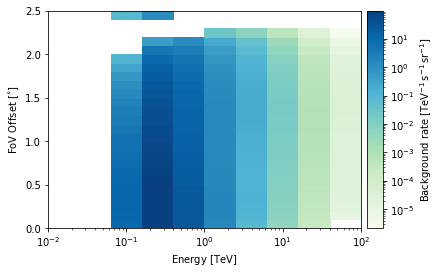

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2012_2013a.fits
(55, 60) (90, 270)


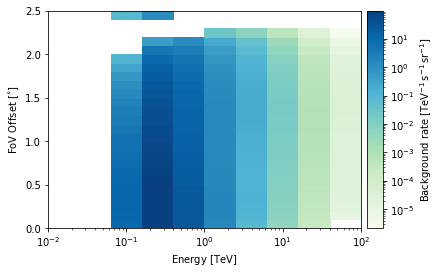

 18%|████████████████▍                                                                            | 3/17 [09:33<39:30, 169.35s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2012_2013a.fits
(0, 10) (-90, 90)


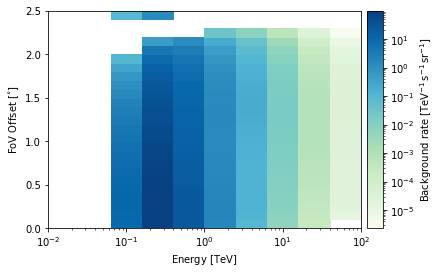

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2012_2013b.fits
(10, 20) (-90, 90)


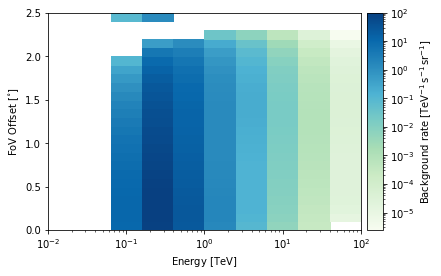

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2012_2013b.fits
(20, 30) (-90, 90)


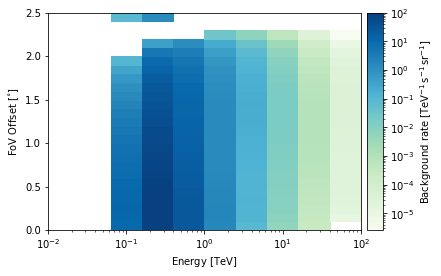

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2012_2013b.fits
(30, 40) (-90, 90)


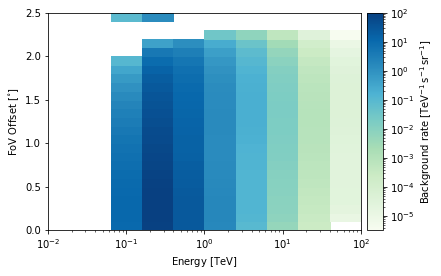

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2012_2013b.fits
(40, 45) (-90, 90)


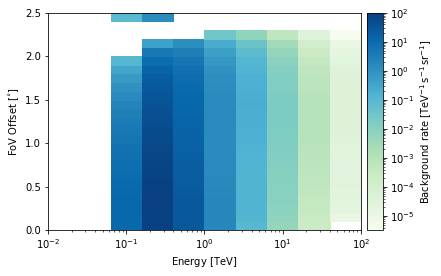

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2012_2013b.fits
(45, 50) (-90, 90)


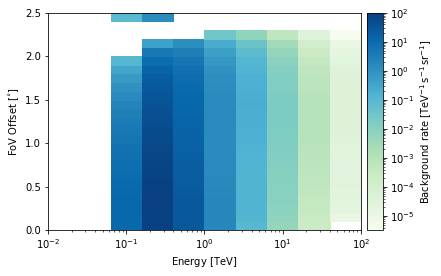

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2012_2013b.fits
(50, 55) (-90, 90)


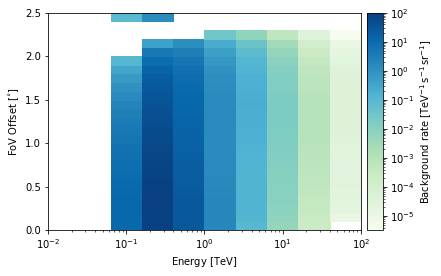

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2012_2013b.fits
(55, 60) (-90, 90)


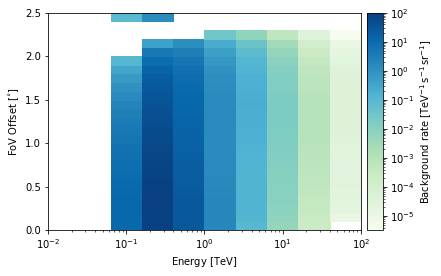

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2012_2013b.fits
(0, 10) (90, 270)


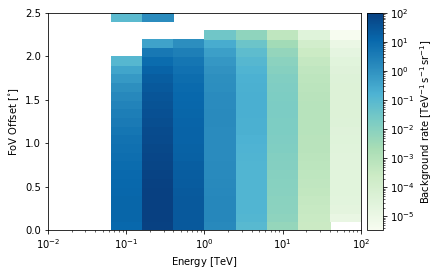

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2012_2013b.fits
(10, 20) (90, 270)


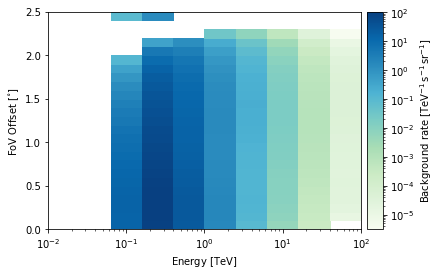

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2012_2013b.fits
(20, 30) (90, 270)


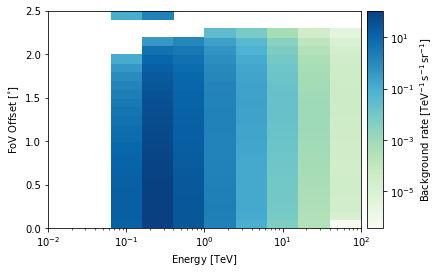

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2012_2013b.fits
(30, 40) (90, 270)


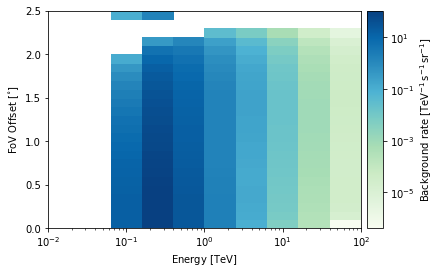

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2012_2013b.fits
(40, 45) (90, 270)


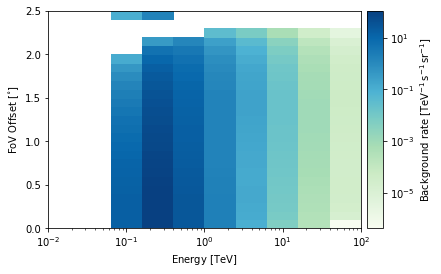

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2012_2013b.fits
(45, 50) (90, 270)


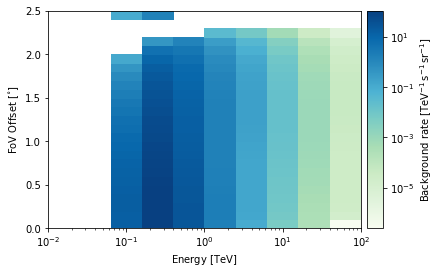

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2012_2013b.fits
(50, 55) (90, 270)


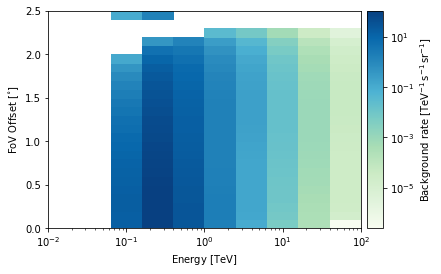

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2012_2013b.fits
(55, 60) (90, 270)


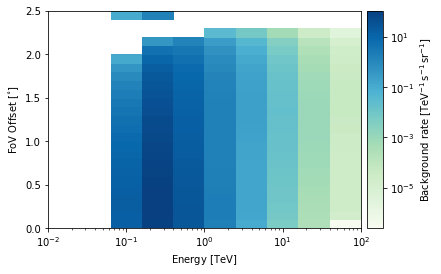

 24%|█████████████████████▉                                                                       | 4/17 [10:18<26:05, 120.41s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2012_2013b.fits
(0, 10) (-90, 90)


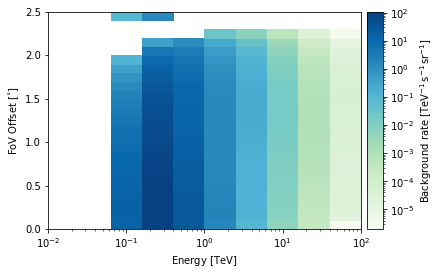

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2013_2014a.fits
(10, 20) (-90, 90)


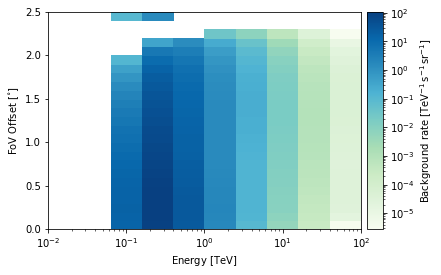

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2013_2014a.fits
(20, 30) (-90, 90)


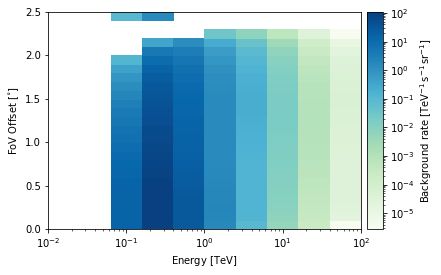

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2013_2014a.fits
(30, 40) (-90, 90)


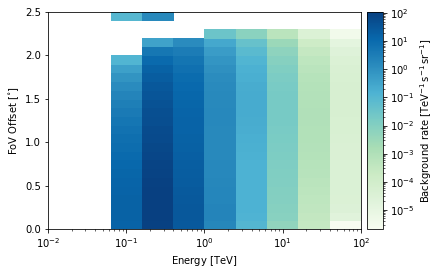

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2013_2014a.fits
(40, 45) (-90, 90)


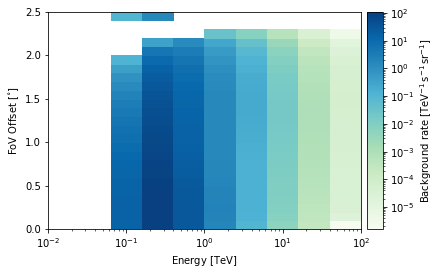

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2013_2014a.fits
(45, 50) (-90, 90)


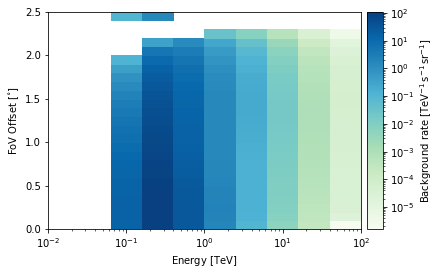

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2013_2014a.fits
(50, 55) (-90, 90)


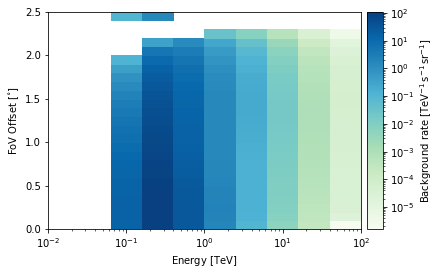

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2013_2014a.fits
(55, 60) (-90, 90)


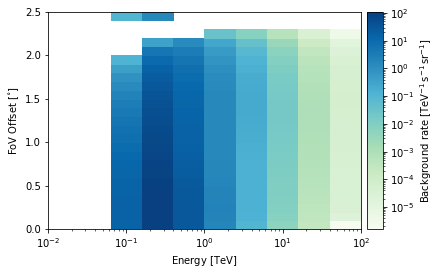

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2013_2014a.fits
(0, 10) (90, 270)


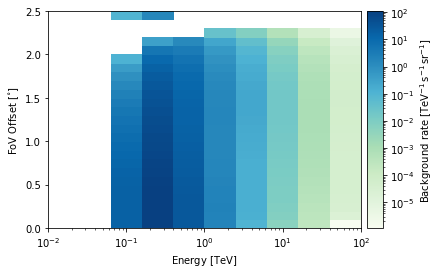

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2013_2014a.fits
(10, 20) (90, 270)


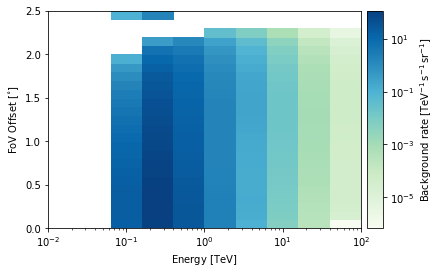

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2013_2014a.fits
(20, 30) (90, 270)


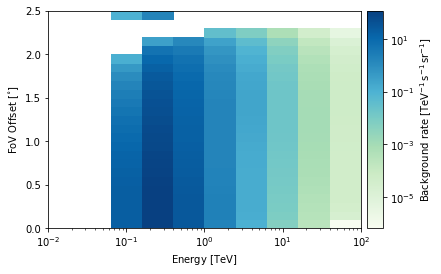

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2013_2014a.fits
(30, 40) (90, 270)


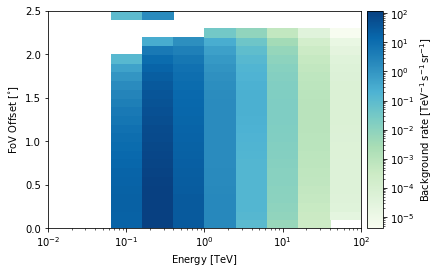

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2013_2014a.fits
(40, 45) (90, 270)


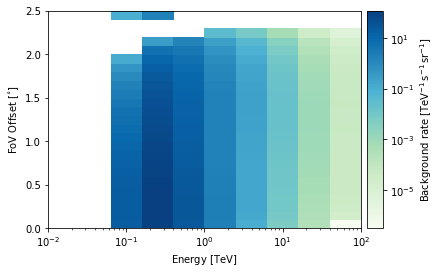

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2013_2014a.fits
(45, 50) (90, 270)


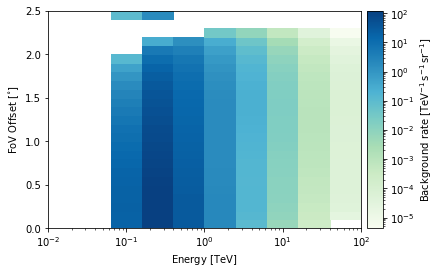

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2013_2014a.fits
(50, 55) (90, 270)


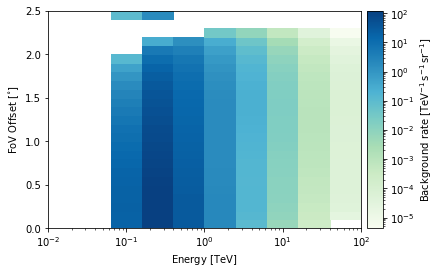

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2013_2014a.fits
(55, 60) (90, 270)


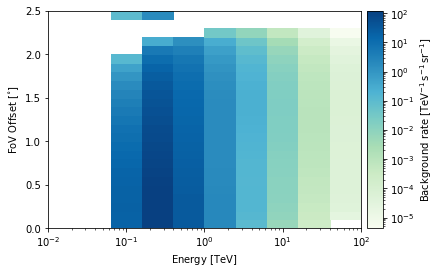

 29%|███████████████████████████▋                                                                  | 5/17 [11:05<18:46, 93.88s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2013_2014a.fits
(0, 10) (-90, 90)


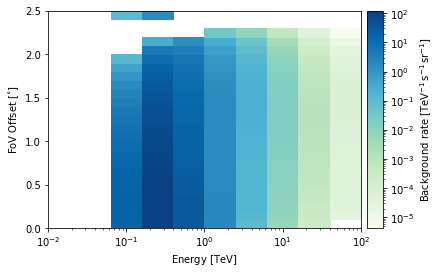

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2013_2014b.fits
(10, 20) (-90, 90)


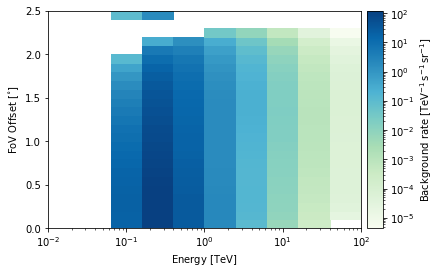

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2013_2014b.fits
(20, 30) (-90, 90)


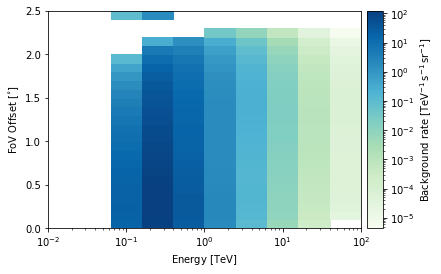

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2013_2014b.fits
(30, 40) (-90, 90)


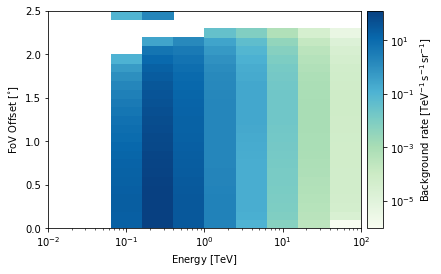

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2013_2014b.fits
(40, 45) (-90, 90)


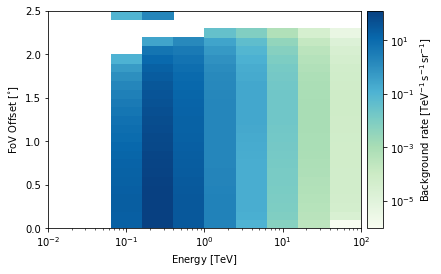

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2013_2014b.fits
(45, 50) (-90, 90)


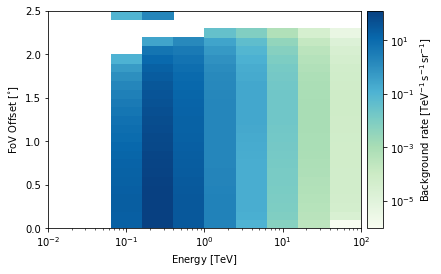

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2013_2014b.fits
(50, 55) (-90, 90)


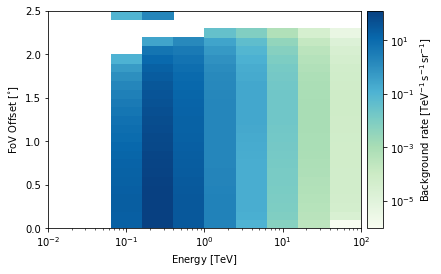

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2013_2014b.fits
(55, 60) (-90, 90)


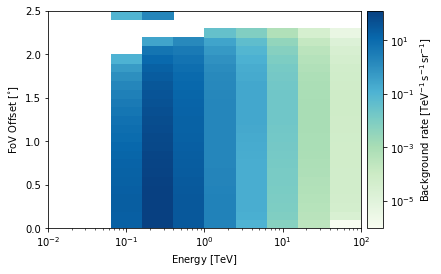

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2013_2014b.fits
(0, 10) (90, 270)


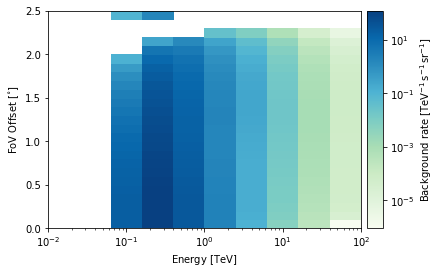

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2013_2014b.fits
(10, 20) (90, 270)


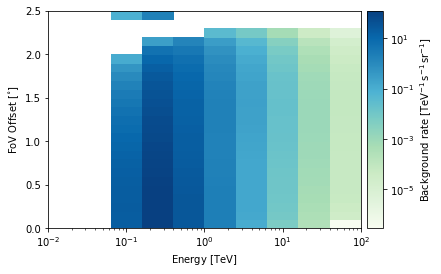

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2013_2014b.fits
(20, 30) (90, 270)


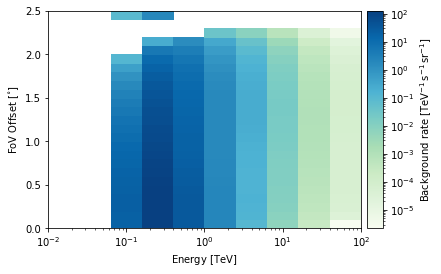

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2013_2014b.fits
(30, 40) (90, 270)


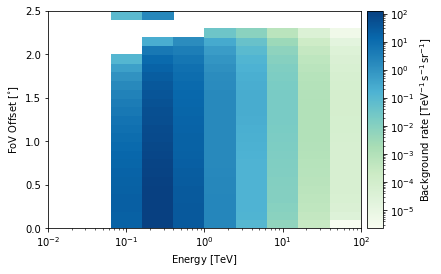

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2013_2014b.fits
(40, 45) (90, 270)


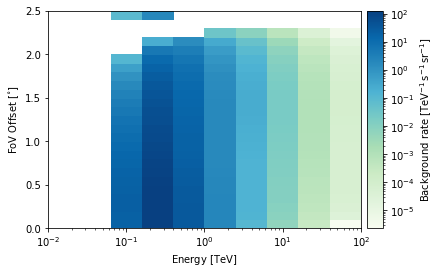

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2013_2014b.fits
(45, 50) (90, 270)


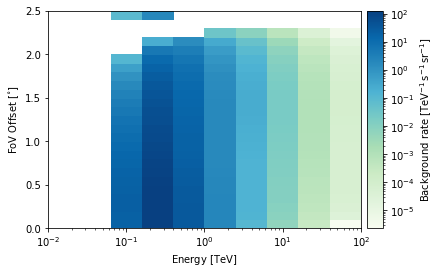

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2013_2014b.fits
(50, 55) (90, 270)


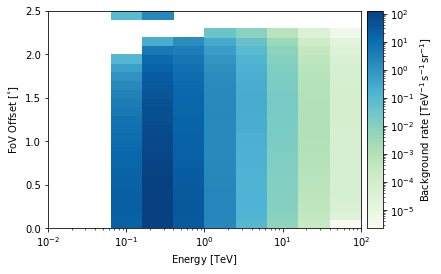

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2013_2014b.fits
(55, 60) (90, 270)


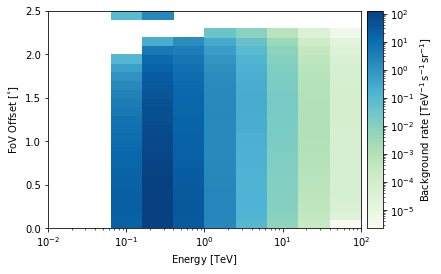

 35%|█████████████████████████████████▏                                                            | 6/17 [11:36<13:19, 72.64s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2013_2014b.fits
(0, 10) (-90, 90)


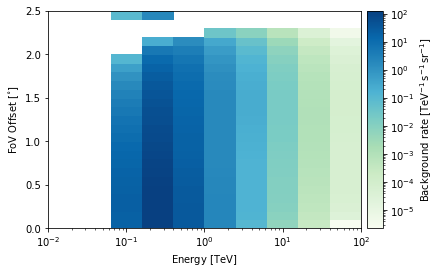

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2014_2015.fits
(10, 20) (-90, 90)


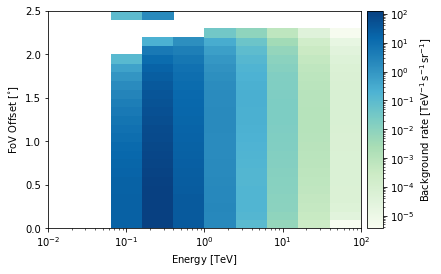

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2014_2015.fits
(20, 30) (-90, 90)


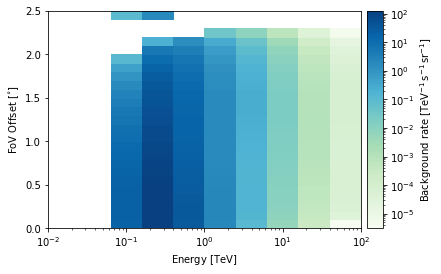

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2014_2015.fits
(30, 40) (-90, 90)


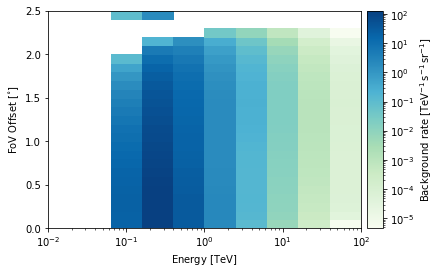

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2014_2015.fits
(40, 45) (-90, 90)


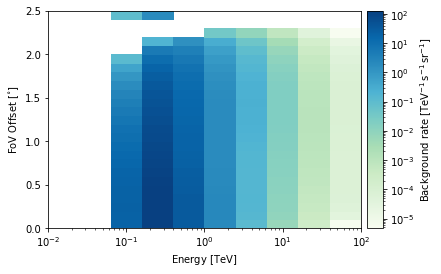

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2014_2015.fits
(45, 50) (-90, 90)


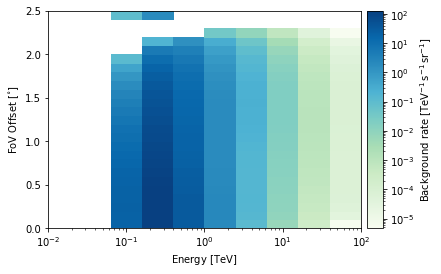

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2014_2015.fits
(50, 55) (-90, 90)


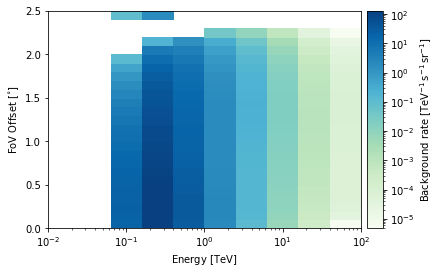

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2014_2015.fits
(55, 60) (-90, 90)


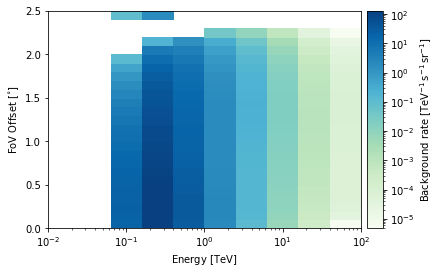

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2014_2015.fits
(0, 10) (90, 270)


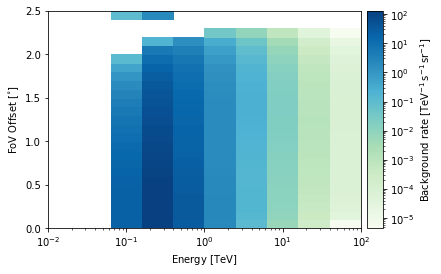

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2014_2015.fits
(10, 20) (90, 270)


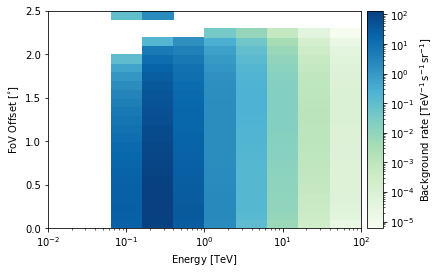

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2014_2015.fits
(20, 30) (90, 270)


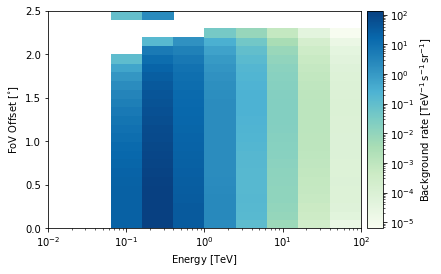

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2014_2015.fits
(30, 40) (90, 270)


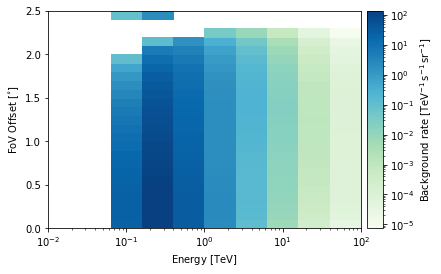

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2014_2015.fits
(40, 45) (90, 270)


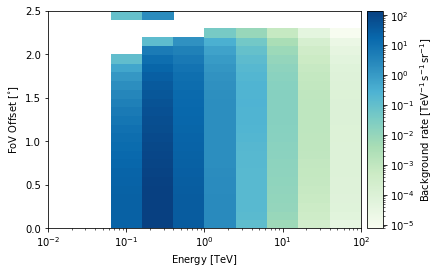

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2014_2015.fits
(45, 50) (90, 270)


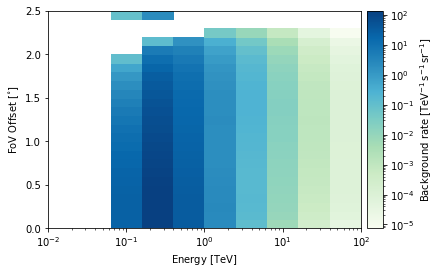

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2014_2015.fits
(50, 55) (90, 270)


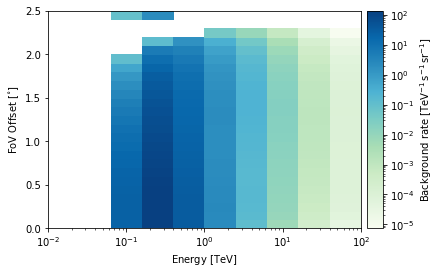

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2014_2015.fits
(55, 60) (90, 270)


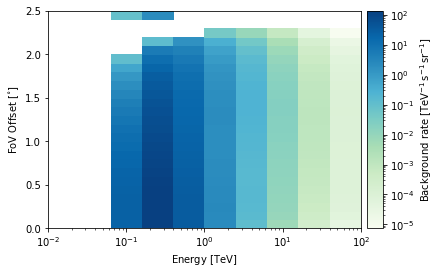

 41%|██████████████████████████████████████▋                                                       | 7/17 [12:37<11:27, 68.74s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2014_2015.fits
(0, 10) (-90, 90)


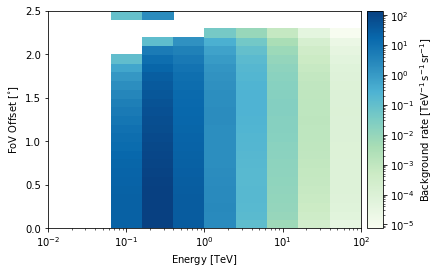

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2015_2016.fits
(10, 20) (-90, 90)


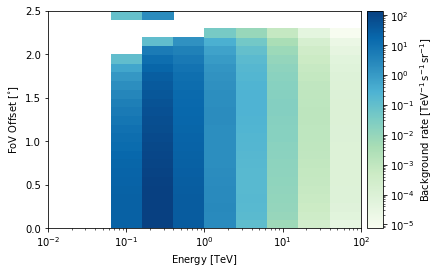

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2015_2016.fits
(20, 30) (-90, 90)


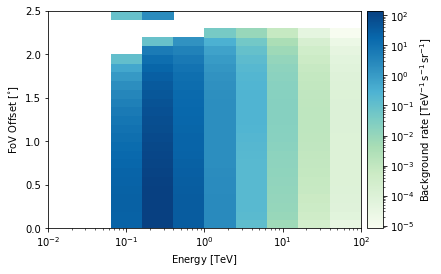

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2015_2016.fits
(30, 40) (-90, 90)


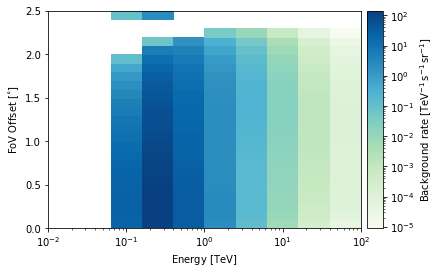

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2015_2016.fits
(40, 45) (-90, 90)


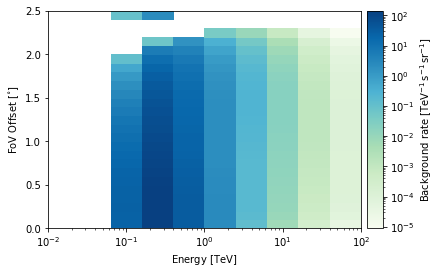

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2015_2016.fits
(45, 50) (-90, 90)


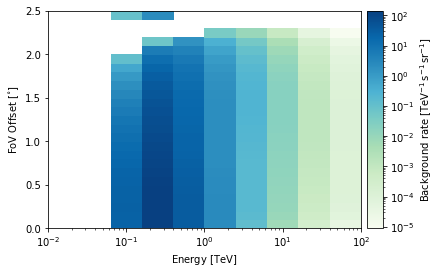

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2015_2016.fits
(50, 55) (-90, 90)


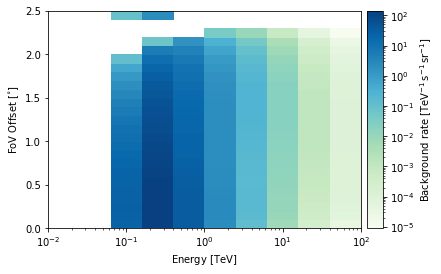

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2015_2016.fits
(55, 60) (-90, 90)


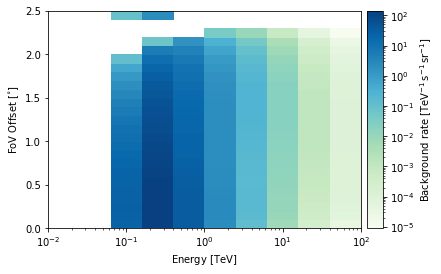

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2015_2016.fits
(0, 10) (90, 270)


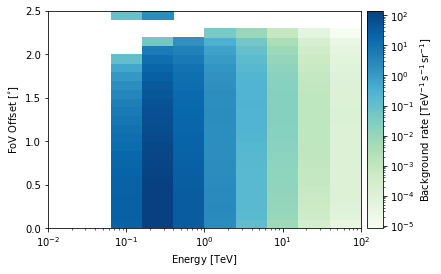

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2015_2016.fits
(10, 20) (90, 270)


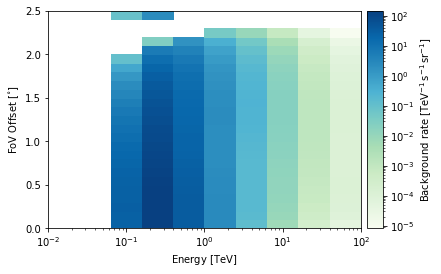

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2015_2016.fits
(20, 30) (90, 270)


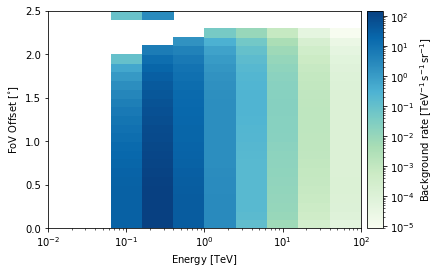

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2015_2016.fits
(30, 40) (90, 270)


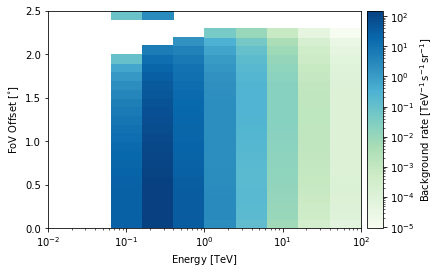

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2015_2016.fits
(40, 45) (90, 270)


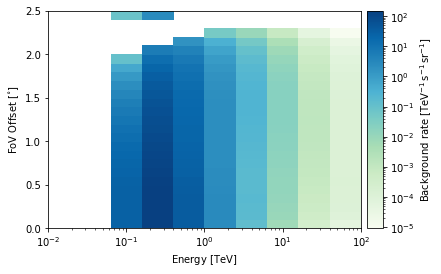

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2015_2016.fits
(45, 50) (90, 270)


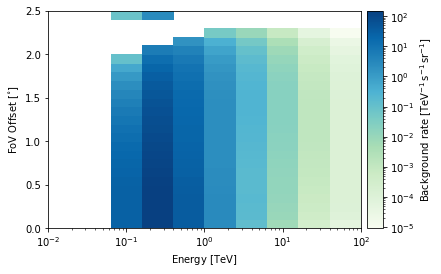

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2015_2016.fits
(50, 55) (90, 270)


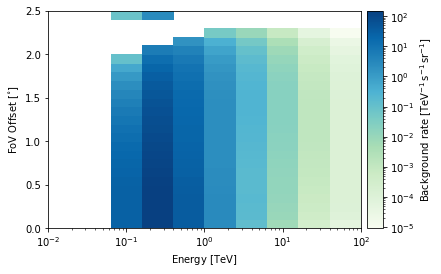

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2015_2016.fits
(55, 60) (90, 270)


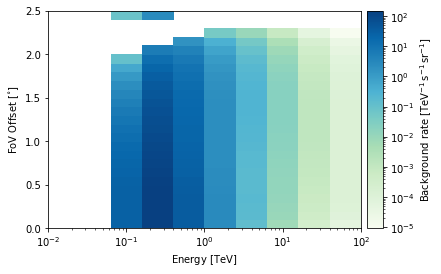

 47%|████████████████████████████████████████████▏                                                 | 8/17 [13:47<10:23, 69.25s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2015_2016.fits
(0, 10) (-90, 90)


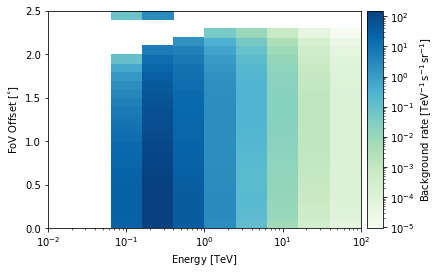

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2016_2017.fits
(10, 20) (-90, 90)


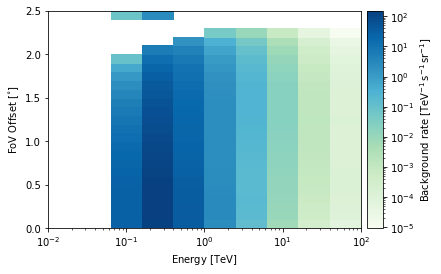

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2016_2017.fits
(20, 30) (-90, 90)


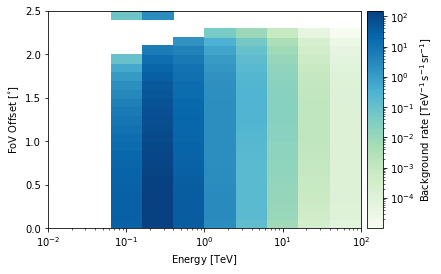

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2016_2017.fits
(30, 40) (-90, 90)


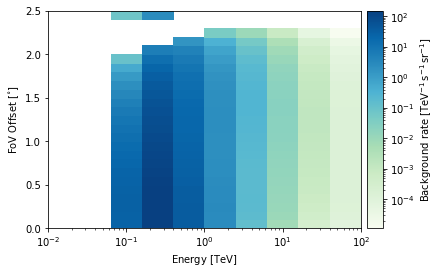

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2016_2017.fits
(40, 45) (-90, 90)


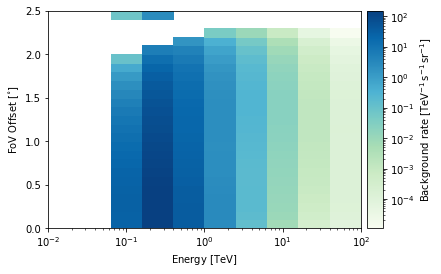

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2016_2017.fits
(45, 50) (-90, 90)


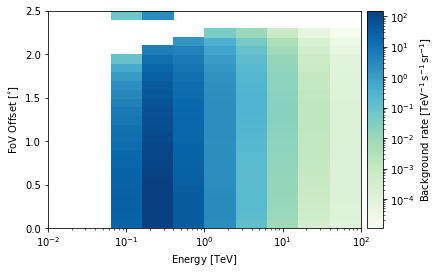

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2016_2017.fits
(50, 55) (-90, 90)


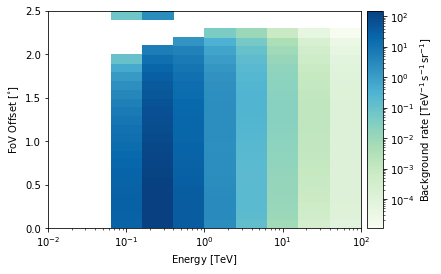

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2016_2017.fits
(55, 60) (-90, 90)


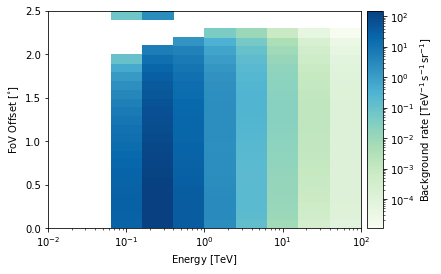

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2016_2017.fits
(0, 10) (90, 270)


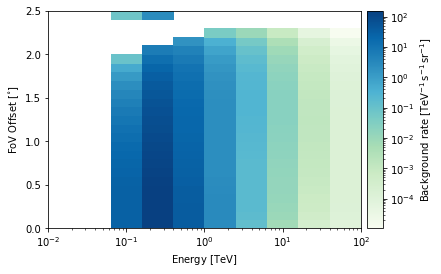

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2016_2017.fits
(10, 20) (90, 270)


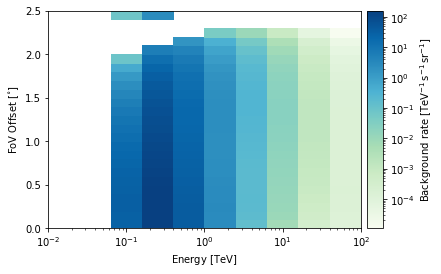

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2016_2017.fits
(20, 30) (90, 270)


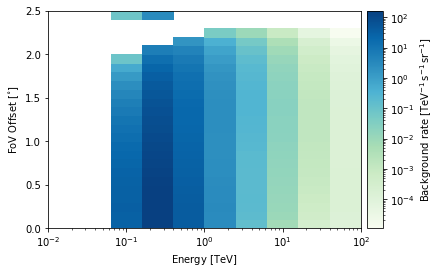

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2016_2017.fits
(30, 40) (90, 270)


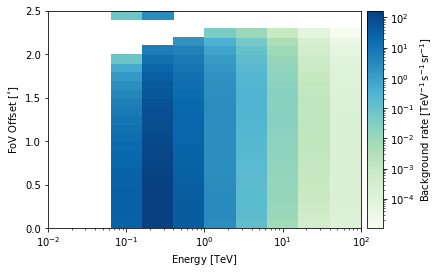

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2016_2017.fits
(40, 45) (90, 270)


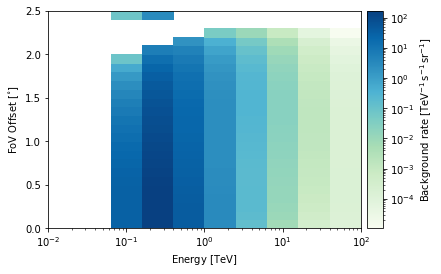

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2016_2017.fits
(45, 50) (90, 270)


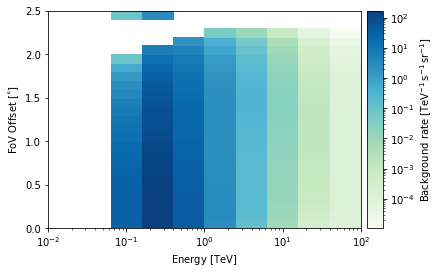

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2016_2017.fits
(50, 55) (90, 270)


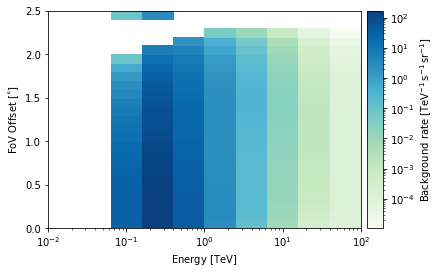

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2016_2017.fits
(55, 60) (90, 270)


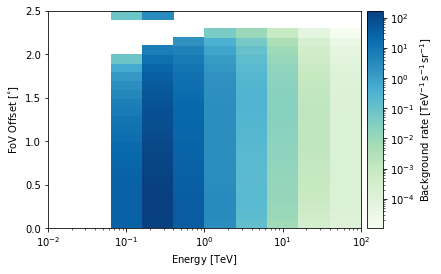

 53%|█████████████████████████████████████████████████▊                                            | 9/17 [15:09<09:44, 73.06s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2016_2017.fits
(0, 10) (-90, 90)


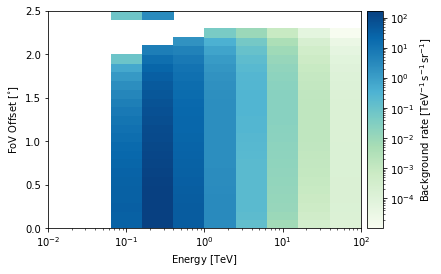

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2017_2018.fits
(10, 20) (-90, 90)


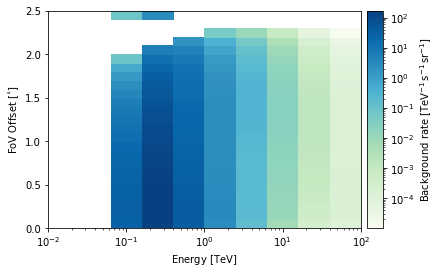

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2017_2018.fits
(20, 30) (-90, 90)


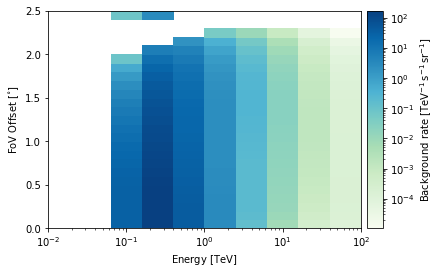

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2017_2018.fits
(30, 40) (-90, 90)


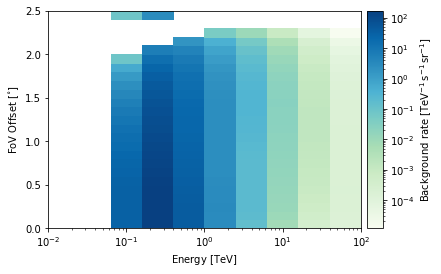

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2017_2018.fits
(40, 45) (-90, 90)


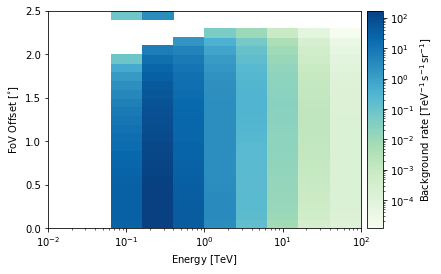

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2017_2018.fits
(45, 50) (-90, 90)


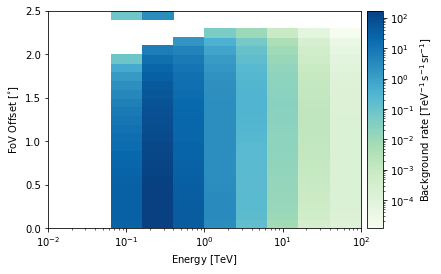

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2017_2018.fits
(50, 55) (-90, 90)


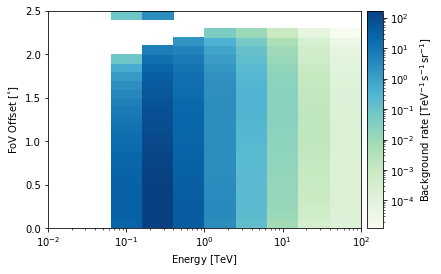

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2017_2018.fits
(55, 60) (-90, 90)


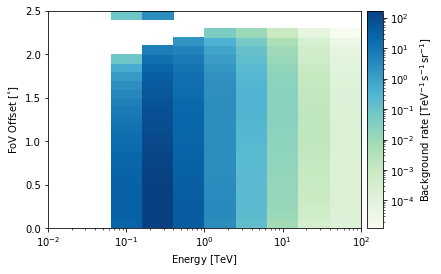

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2017_2018.fits
(0, 10) (90, 270)


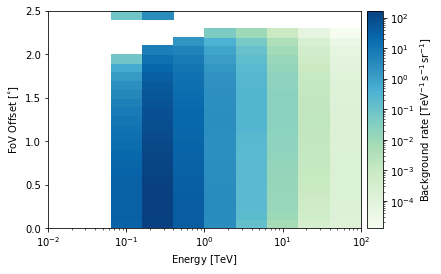

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2017_2018.fits
(10, 20) (90, 270)


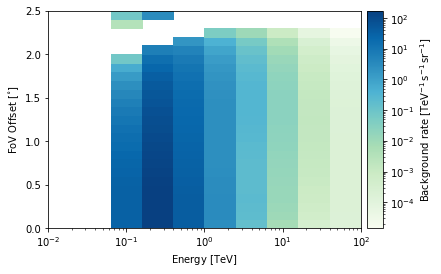

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2017_2018.fits
(20, 30) (90, 270)


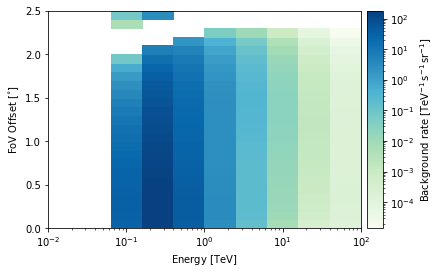

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2017_2018.fits
(30, 40) (90, 270)


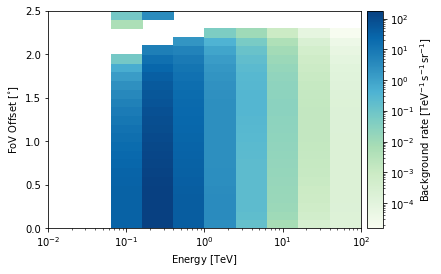

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2017_2018.fits
(40, 45) (90, 270)


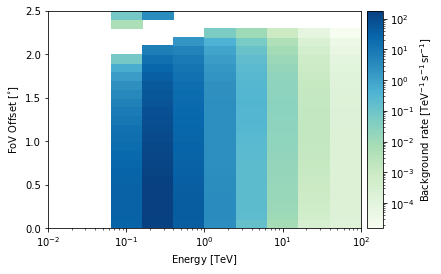

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2017_2018.fits
(45, 50) (90, 270)


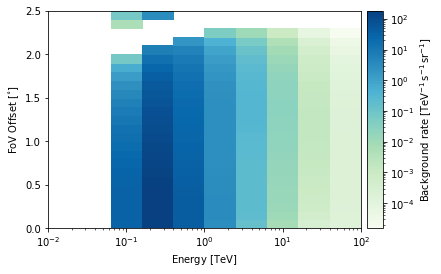

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2017_2018.fits
(50, 55) (90, 270)


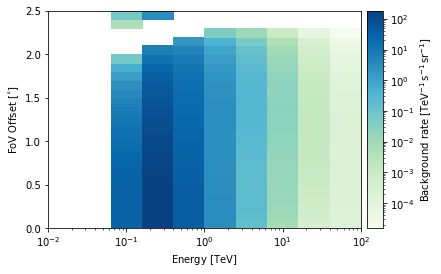

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2017_2018.fits
(55, 60) (90, 270)


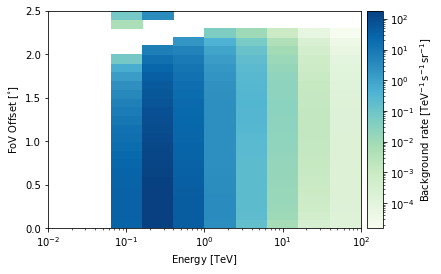

 59%|██████████████████████████████████████████████████████▋                                      | 10/17 [16:32<08:54, 76.35s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2017_2018.fits
(0, 10) (-90, 90)


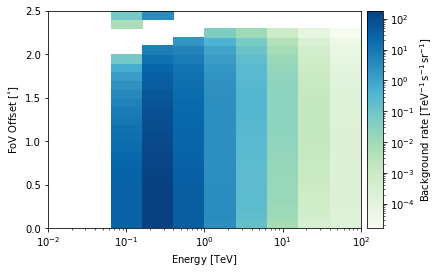

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2018_2019.fits
(10, 20) (-90, 90)


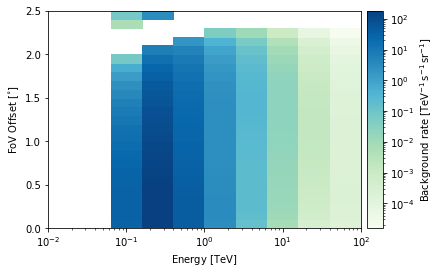

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2018_2019.fits
(20, 30) (-90, 90)


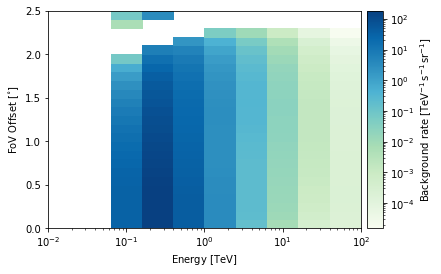

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2018_2019.fits
(30, 40) (-90, 90)


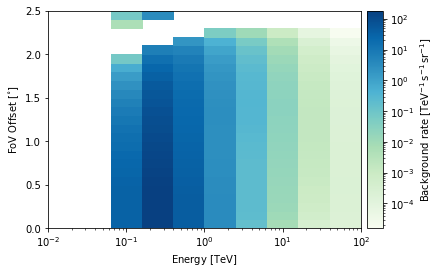

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2018_2019.fits
(40, 45) (-90, 90)


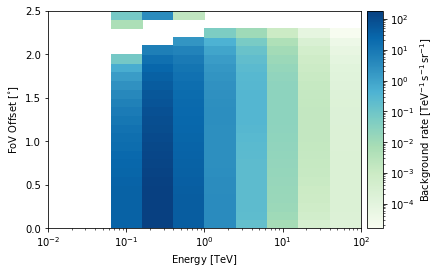

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2018_2019.fits
(45, 50) (-90, 90)


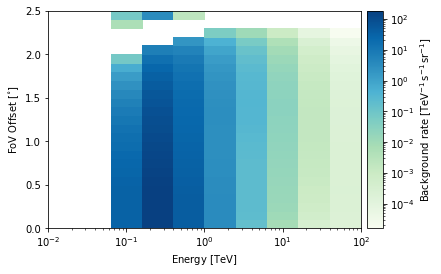

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2018_2019.fits
(50, 55) (-90, 90)


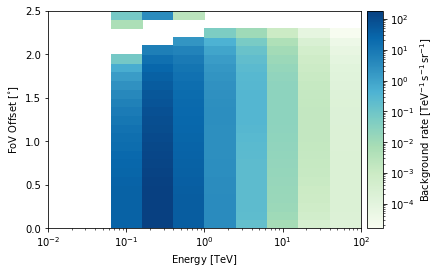

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2018_2019.fits
(55, 60) (-90, 90)


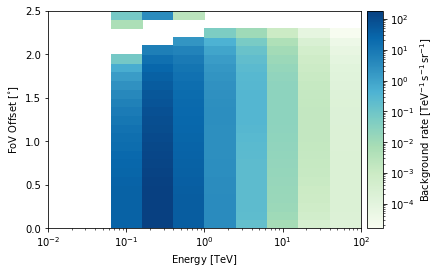

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2018_2019.fits
(0, 10) (90, 270)


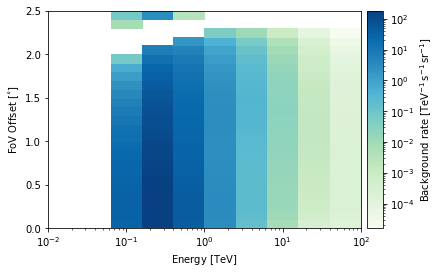

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2018_2019.fits
(10, 20) (90, 270)


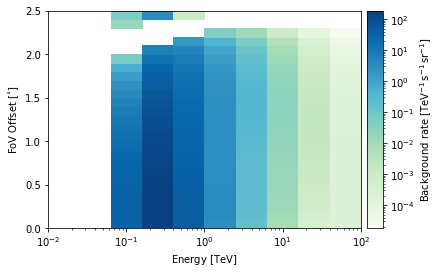

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2018_2019.fits
(20, 30) (90, 270)


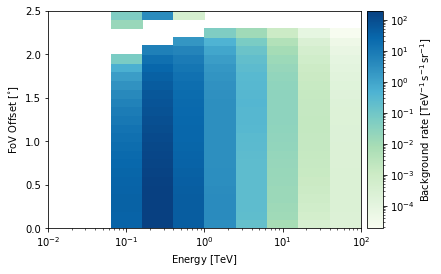

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2018_2019.fits
(30, 40) (90, 270)


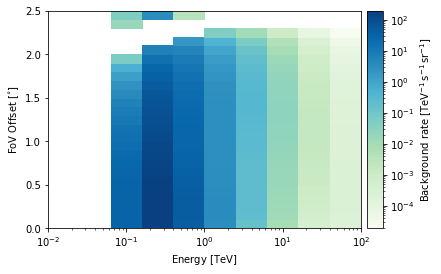

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2018_2019.fits
(40, 45) (90, 270)


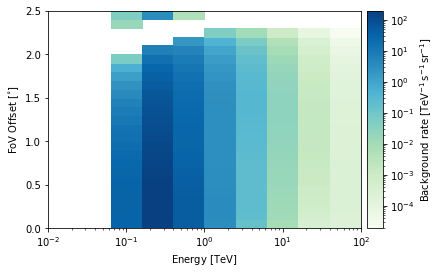

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2018_2019.fits
(45, 50) (90, 270)


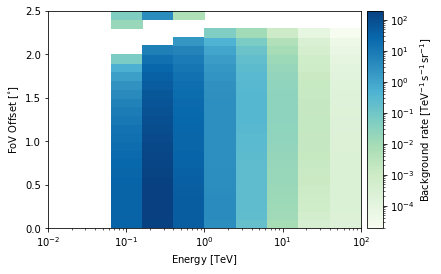

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2018_2019.fits
(50, 55) (90, 270)


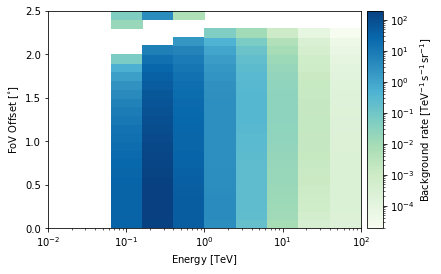

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2018_2019.fits
(55, 60) (90, 270)


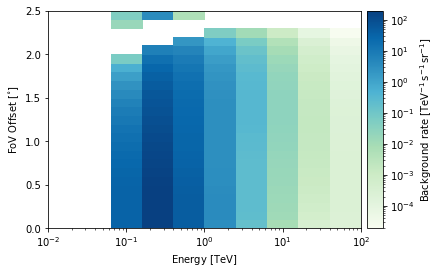

 65%|████████████████████████████████████████████████████████████▏                                | 11/17 [17:41<07:23, 73.97s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2018_2019.fits
(0, 10) (-90, 90)


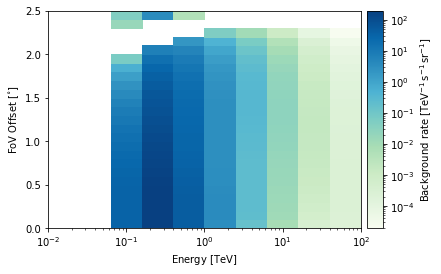

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2019_2020w.fits
(10, 20) (-90, 90)


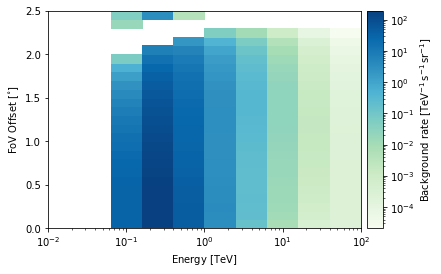

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2019_2020w.fits
(20, 30) (-90, 90)


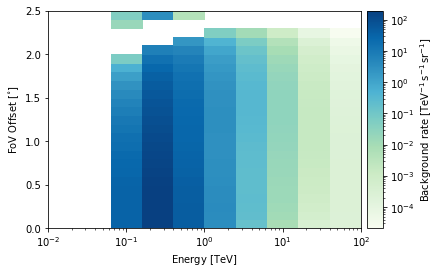

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2019_2020w.fits
(30, 40) (-90, 90)


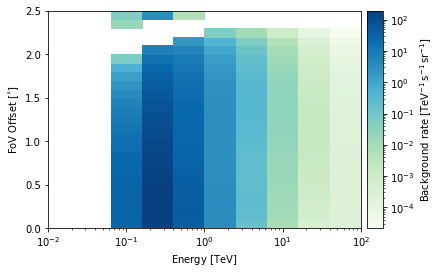

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2019_2020w.fits
(40, 45) (-90, 90)


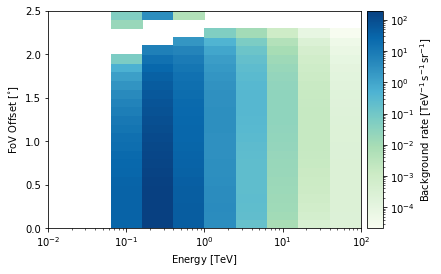

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2019_2020w.fits
(45, 50) (-90, 90)


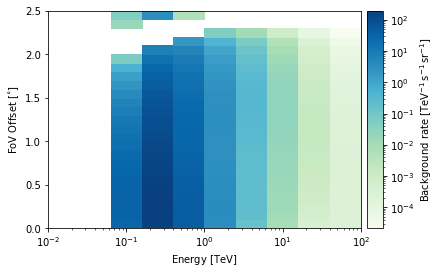

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2019_2020w.fits
(50, 55) (-90, 90)


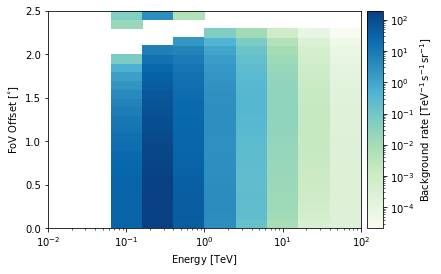

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2019_2020w.fits
(55, 60) (-90, 90)


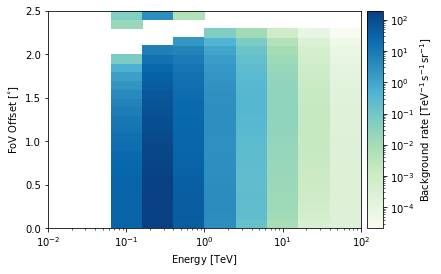

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2019_2020w.fits
(0, 10) (90, 270)


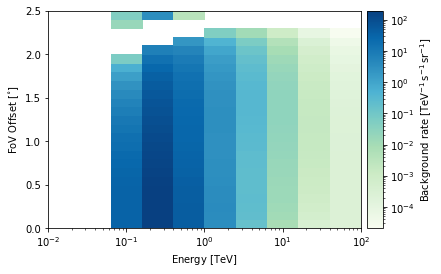

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2019_2020w.fits
(10, 20) (90, 270)


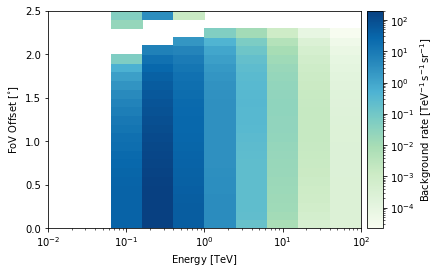

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2019_2020w.fits
(20, 30) (90, 270)


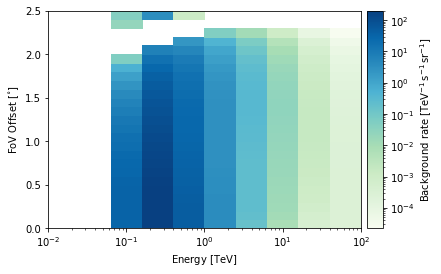

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2019_2020w.fits
(30, 40) (90, 270)


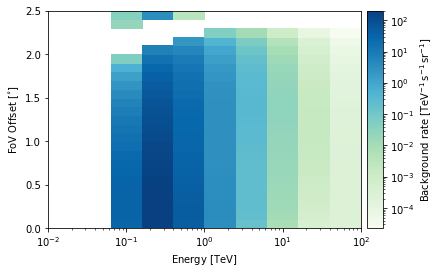

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2019_2020w.fits
(40, 45) (90, 270)


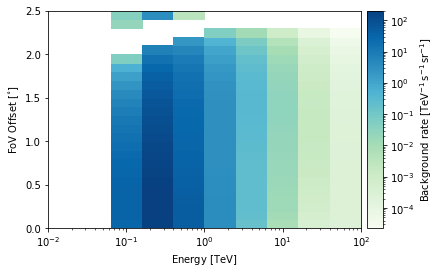

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2019_2020w.fits
(45, 50) (90, 270)


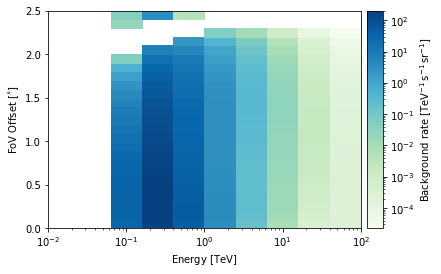

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2019_2020w.fits
(50, 55) (90, 270)


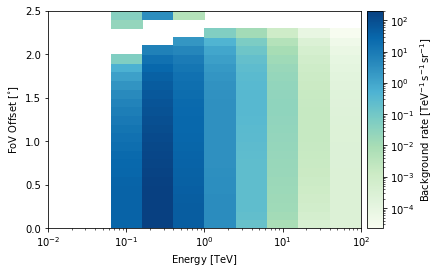

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2019_2020w.fits
(55, 60) (90, 270)


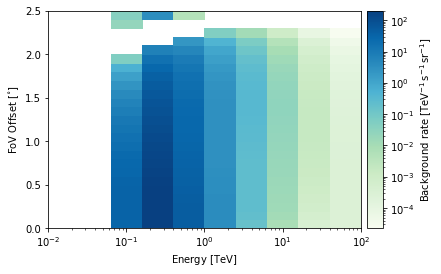

 71%|█████████████████████████████████████████████████████████████████▋                           | 12/17 [18:16<05:10, 62.01s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2019_2020w.fits
(0, 10) (-90, 90)


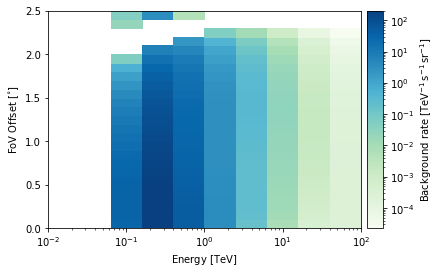

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2020_2020s.fits
(10, 20) (-90, 90)


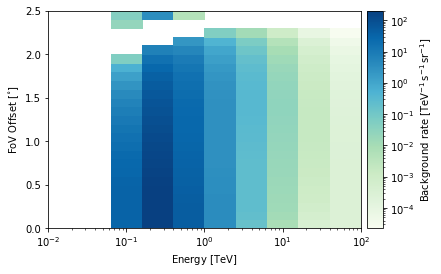

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2020_2020s.fits
(20, 30) (-90, 90)


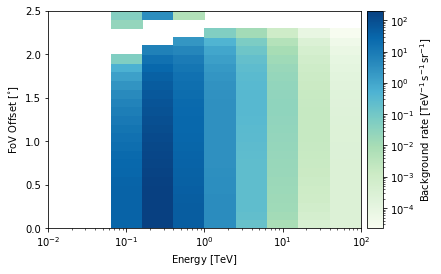

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2020_2020s.fits
(30, 40) (-90, 90)


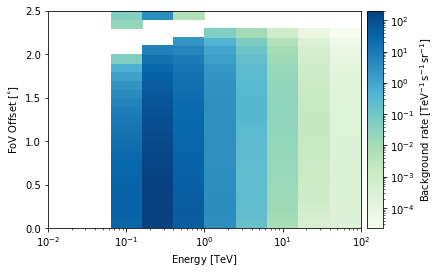

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2020_2020s.fits
(40, 45) (-90, 90)


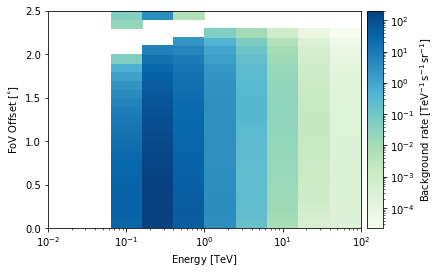

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2020_2020s.fits
(45, 50) (-90, 90)


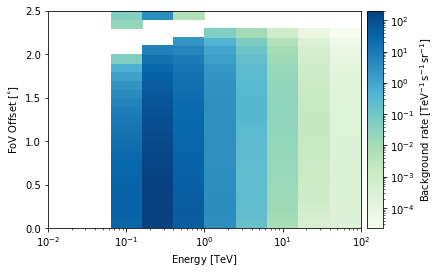

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2020_2020s.fits
(50, 55) (-90, 90)


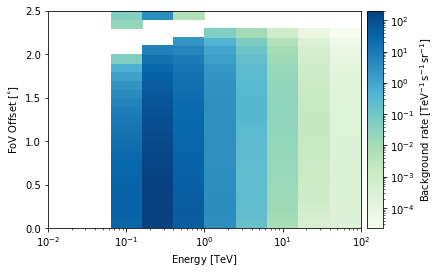

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2020_2020s.fits
(55, 60) (-90, 90)


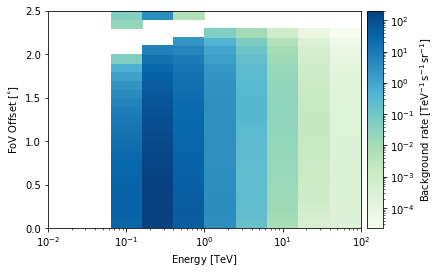

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2020_2020s.fits
(0, 10) (90, 270)


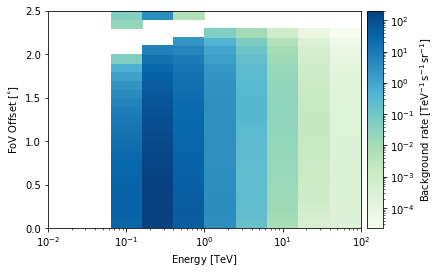

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2020_2020s.fits
(10, 20) (90, 270)


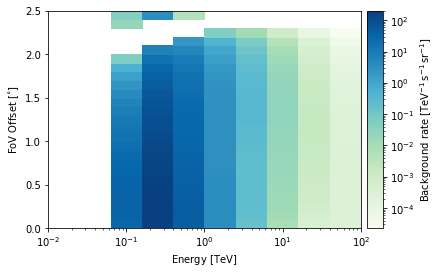

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2020_2020s.fits
(20, 30) (90, 270)


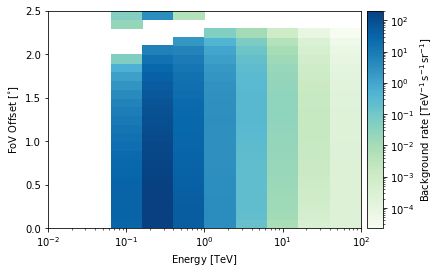

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2020_2020s.fits
(30, 40) (90, 270)


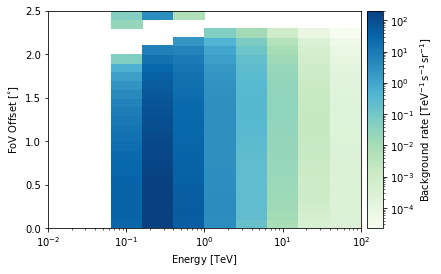

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2020_2020s.fits
(40, 45) (90, 270)


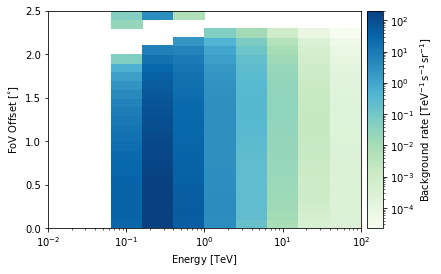

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2020_2020s.fits
(45, 50) (90, 270)


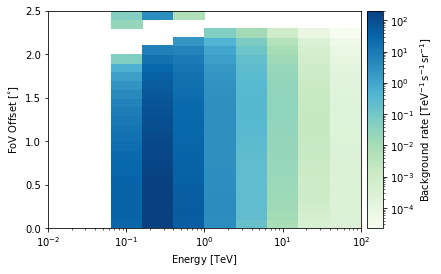

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2020_2020s.fits
(50, 55) (90, 270)


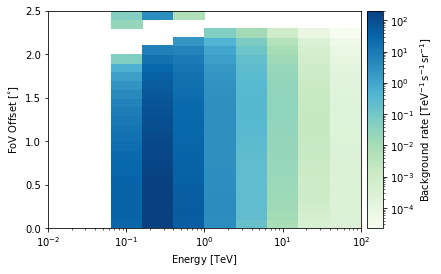

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2020_2020s.fits
(55, 60) (90, 270)


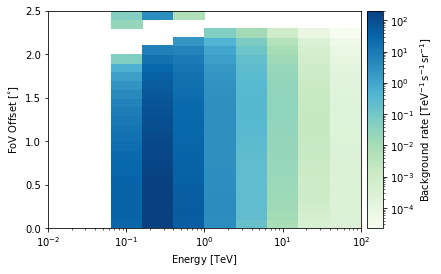

 76%|███████████████████████████████████████████████████████████████████████                      | 13/17 [18:31<03:11, 47.83s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2020_2020s.fits
(0, 10) (-90, 90)


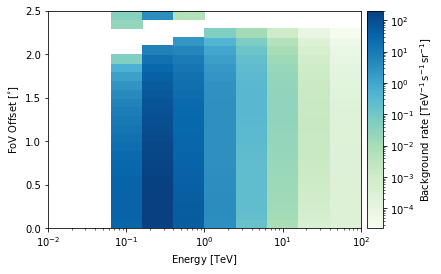

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2020_2021w.fits
(10, 20) (-90, 90)


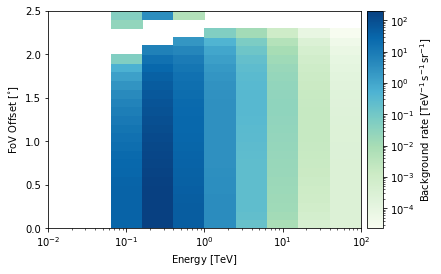

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2020_2021w.fits
(20, 30) (-90, 90)


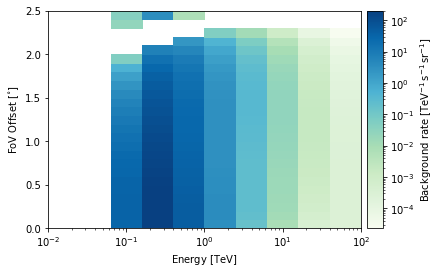

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2020_2021w.fits
(30, 40) (-90, 90)


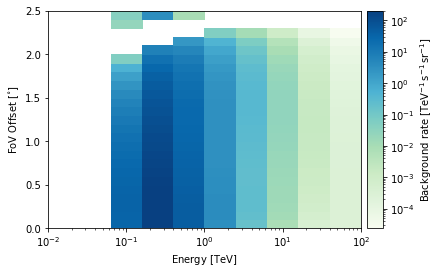

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2020_2021w.fits
(40, 45) (-90, 90)


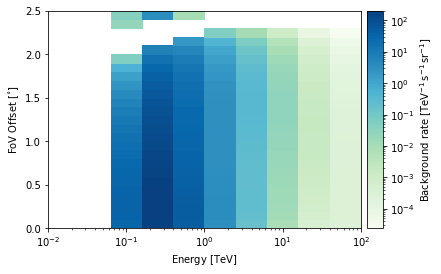

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2020_2021w.fits
(45, 50) (-90, 90)


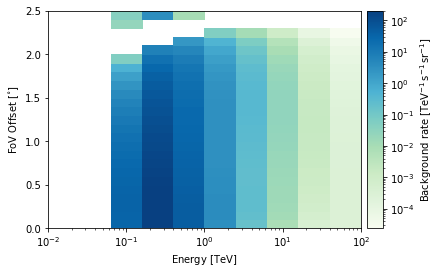

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2020_2021w.fits
(50, 55) (-90, 90)


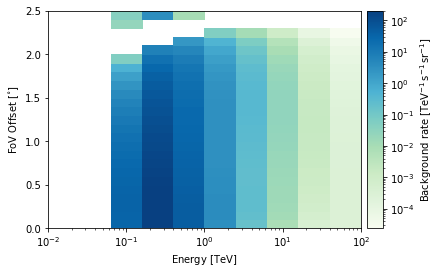

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2020_2021w.fits
(55, 60) (-90, 90)


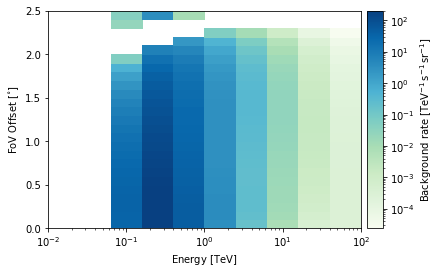

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2020_2021w.fits
(0, 10) (90, 270)


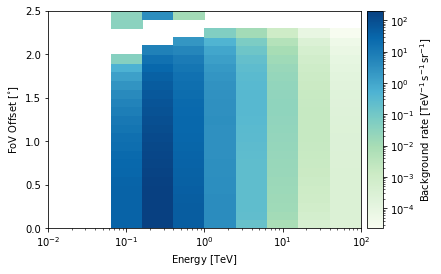

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2020_2021w.fits
(10, 20) (90, 270)


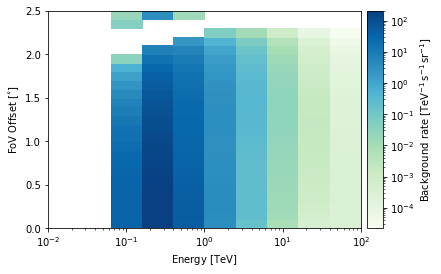

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2020_2021w.fits
(20, 30) (90, 270)


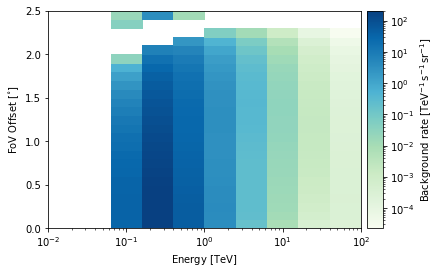

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2020_2021w.fits
(30, 40) (90, 270)


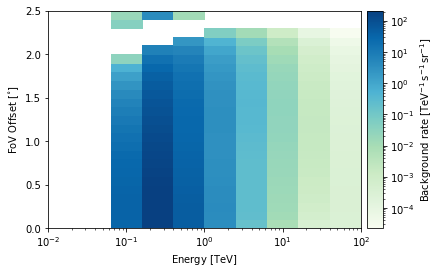

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2020_2021w.fits
(40, 45) (90, 270)


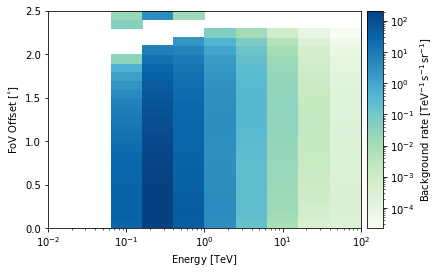

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2020_2021w.fits
(45, 50) (90, 270)


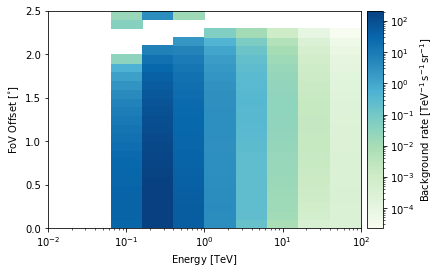

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2020_2021w.fits
(50, 55) (90, 270)


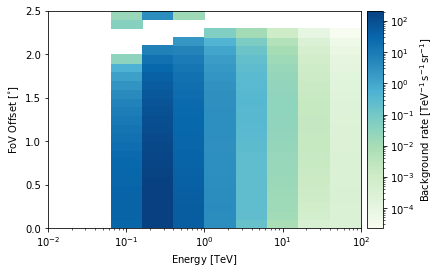

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2020_2021w.fits
(55, 60) (90, 270)


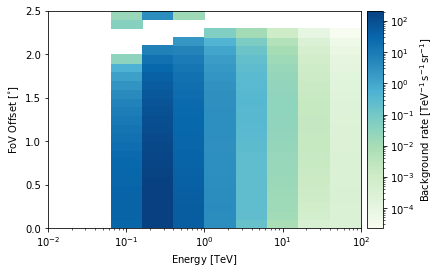

 82%|████████████████████████████████████████████████████████████████████████████▌                | 14/17 [19:21<02:25, 48.65s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2020_2021w.fits
(0, 10) (-90, 90)


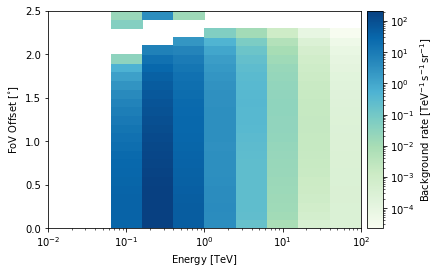

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2021_2021s.fits
(10, 20) (-90, 90)


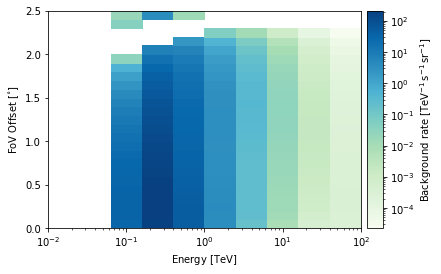

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2021_2021s.fits
(20, 30) (-90, 90)


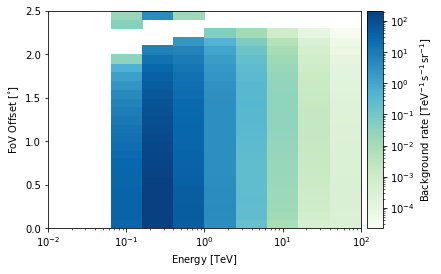

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2021_2021s.fits
(30, 40) (-90, 90)


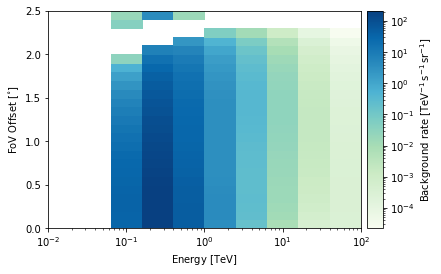

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2021_2021s.fits
(40, 45) (-90, 90)


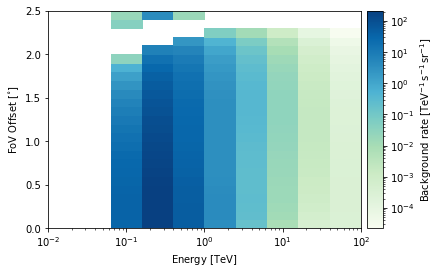

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2021_2021s.fits
(45, 50) (-90, 90)


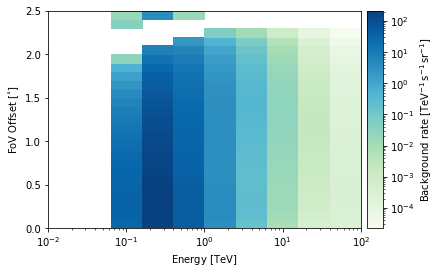

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2021_2021s.fits
(50, 55) (-90, 90)


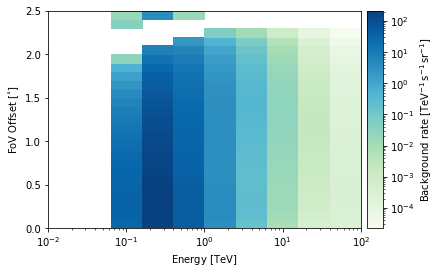

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2021_2021s.fits
(55, 60) (-90, 90)


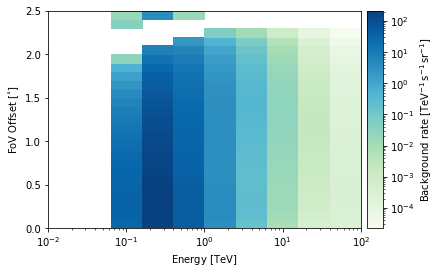

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2021_2021s.fits
(0, 10) (90, 270)


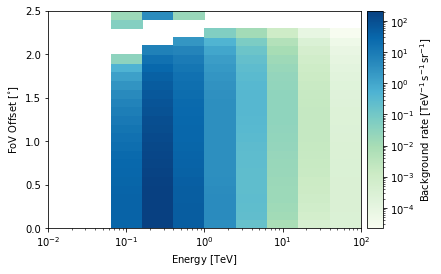

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2021_2021s.fits
(10, 20) (90, 270)


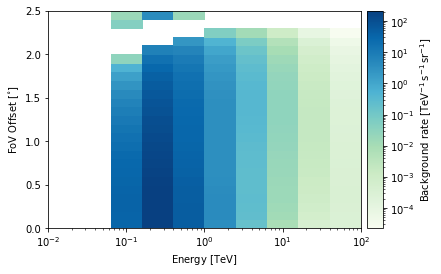

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2021_2021s.fits
(20, 30) (90, 270)


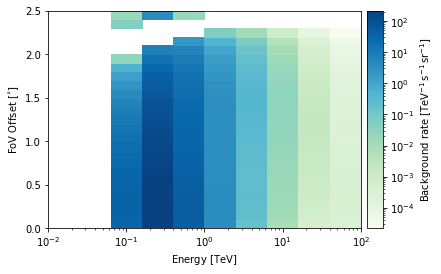

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2021_2021s.fits
(30, 40) (90, 270)


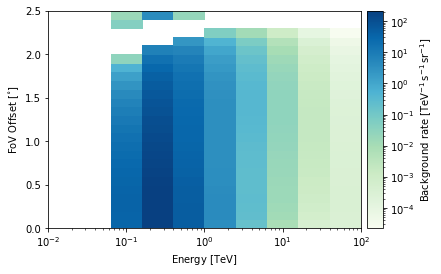

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2021_2021s.fits
(40, 45) (90, 270)


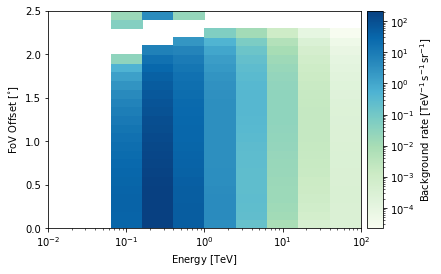

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2021_2021s.fits
(45, 50) (90, 270)


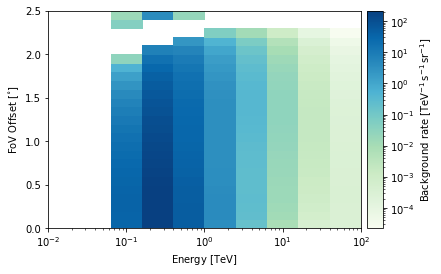

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2021_2021s.fits
(50, 55) (90, 270)


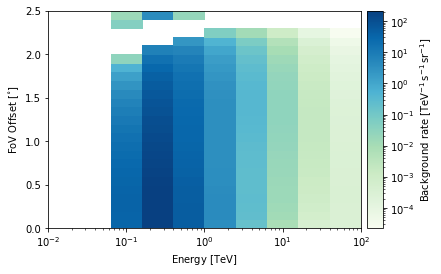

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2021_2021s.fits
(55, 60) (90, 270)


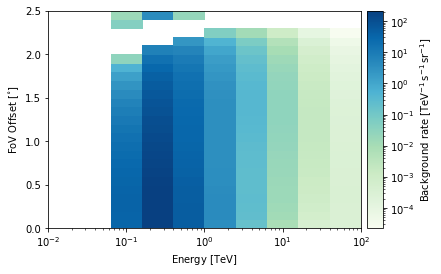

 88%|██████████████████████████████████████████████████████████████████████████████████           | 15/17 [19:53<01:26, 43.45s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2021_2021s.fits
(0, 10) (-90, 90)


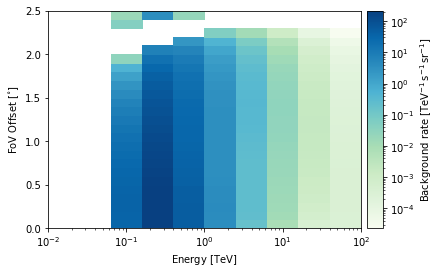

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2021_2022w.fits
(10, 20) (-90, 90)


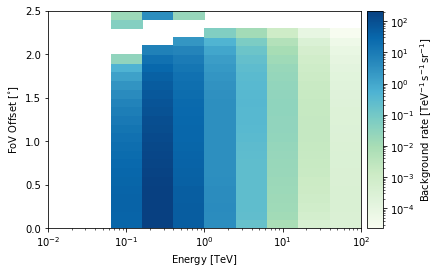

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2021_2022w.fits
(20, 30) (-90, 90)


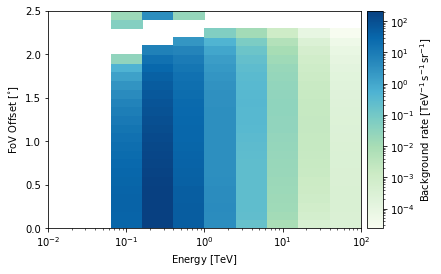

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2021_2022w.fits
(30, 40) (-90, 90)


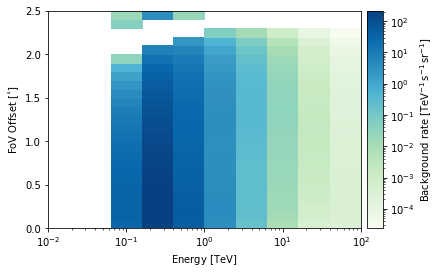

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2021_2022w.fits
(40, 45) (-90, 90)


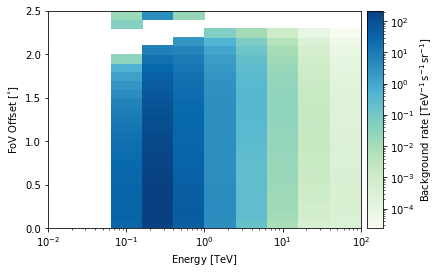

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2021_2022w.fits
(45, 50) (-90, 90)


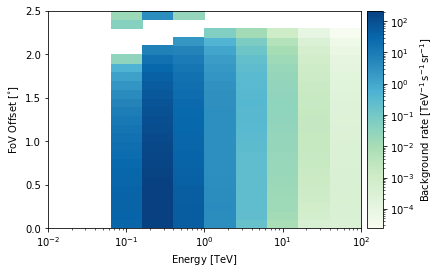

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2021_2022w.fits
(50, 55) (-90, 90)


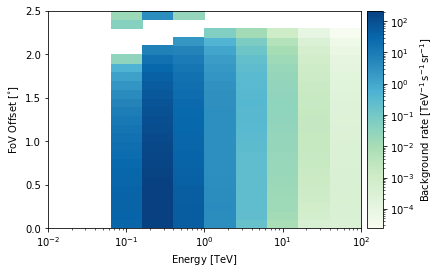

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2021_2022w.fits
(55, 60) (-90, 90)


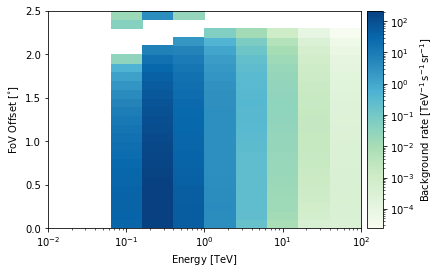

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2021_2022w.fits
(0, 10) (90, 270)


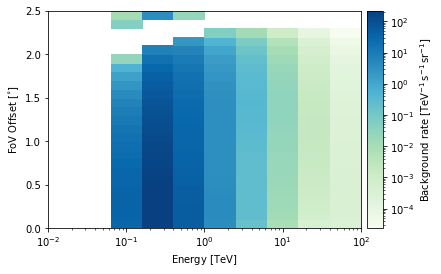

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2021_2022w.fits
(10, 20) (90, 270)


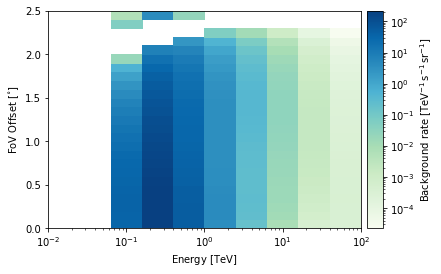

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2021_2022w.fits
(20, 30) (90, 270)


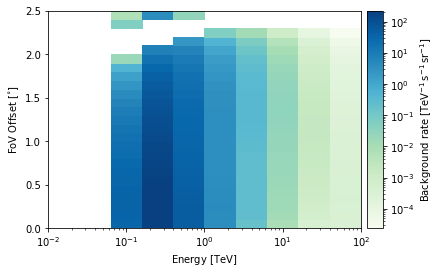

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2021_2022w.fits
(30, 40) (90, 270)


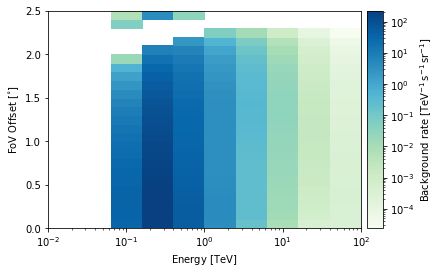

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2021_2022w.fits
(40, 45) (90, 270)


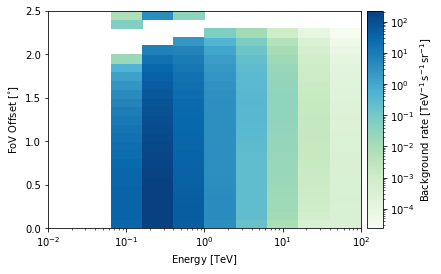

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2021_2022w.fits
(45, 50) (90, 270)


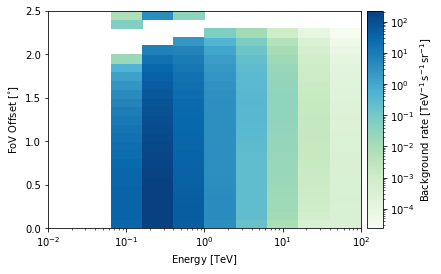

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2021_2022w.fits
(50, 55) (90, 270)


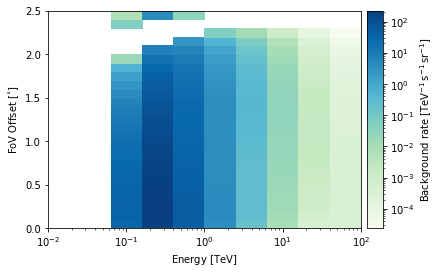

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2021_2022w.fits
(55, 60) (90, 270)


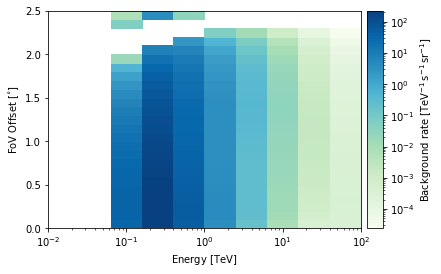

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 16/17 [20:41<00:44, 44.82s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2021_2022w.fits
(0, 10) (-90, 90)


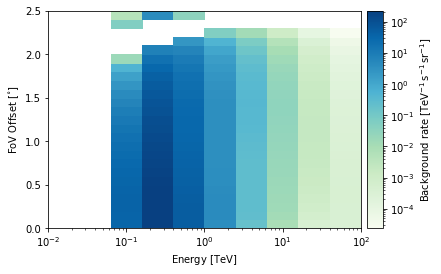

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2022_2022s.fits
(10, 20) (-90, 90)


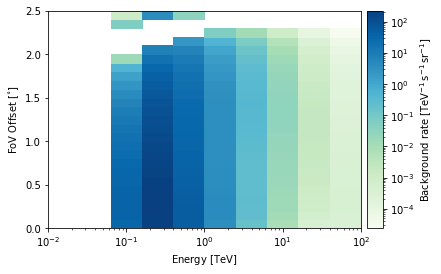

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2022_2022s.fits
(20, 30) (-90, 90)


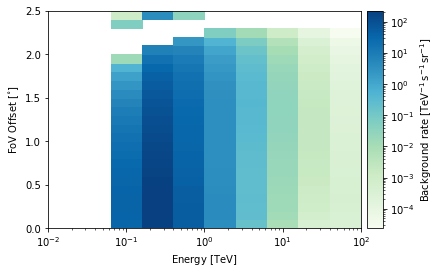

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2022_2022s.fits
(30, 40) (-90, 90)


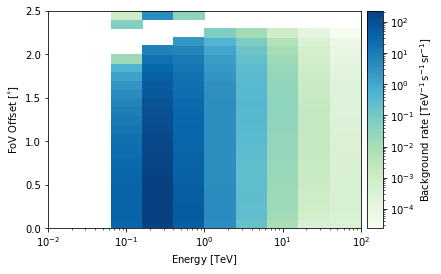

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2022_2022s.fits
(40, 45) (-90, 90)


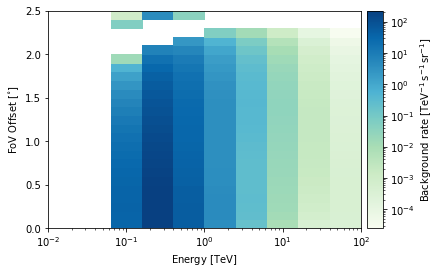

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2022_2022s.fits
(45, 50) (-90, 90)


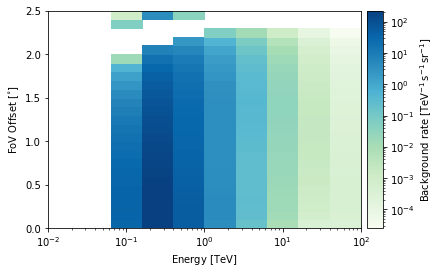

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2022_2022s.fits
(50, 55) (-90, 90)


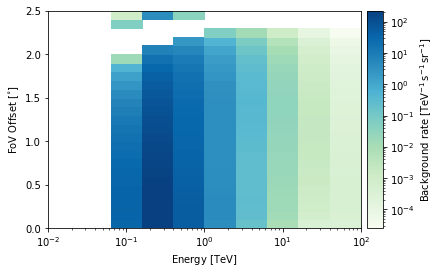

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2022_2022s.fits
(55, 60) (-90, 90)


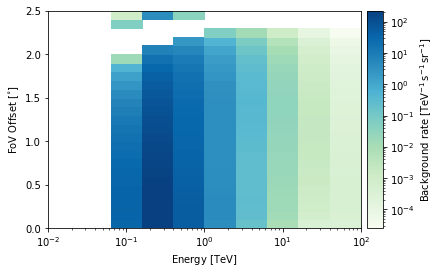

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2022_2022s.fits
(0, 10) (90, 270)


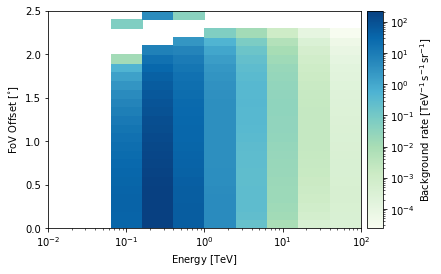

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2022_2022s.fits
(10, 20) (90, 270)


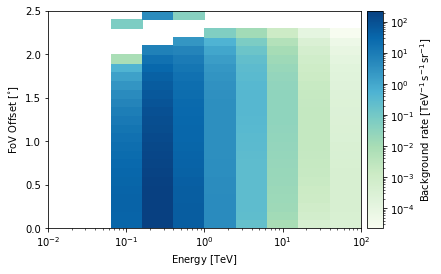

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2022_2022s.fits
(20, 30) (90, 270)


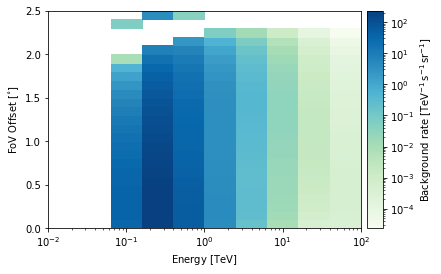

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2022_2022s.fits
(30, 40) (90, 270)


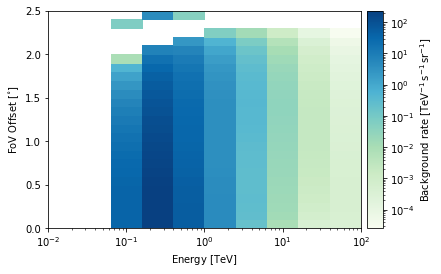

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2022_2022s.fits
(40, 45) (90, 270)


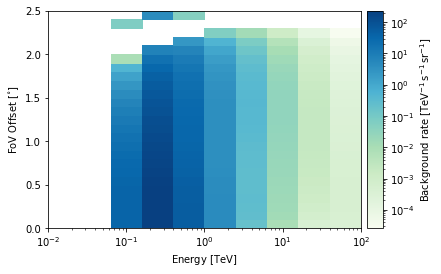

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2022_2022s.fits
(45, 50) (90, 270)


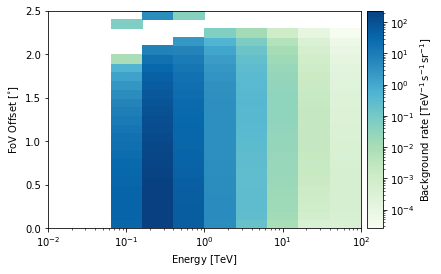

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2022_2022s.fits
(50, 55) (90, 270)


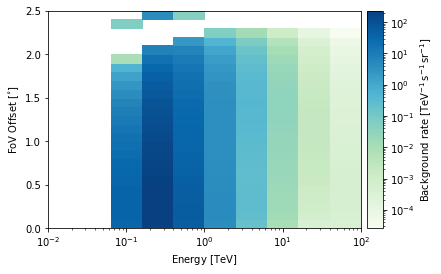

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2022_2022s.fits
(55, 60) (90, 270)


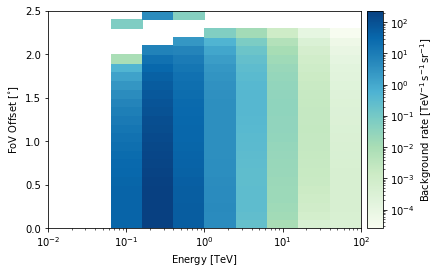

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [21:59<00:00, 77.63s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2022_2022s.fits


In [33]:
from datetime import datetime
import os

path = '/raid/romulus/swong/mydl3/lookup_2d_moderate_epochs_poly/'

import os
if not os.path.exists(path):
    os.makedirs(path)

for epoch in tqdm(epochs):
    for az in azimuths:
        for ze in zeniths:
            print(ze,az)
            background_meta = {"zen_min": str(ze[0]), "zen_max": str(ze[1]),"e_min": str(emin),
                           "e_max": str(emax), "az_min": str(az[0]), "az_max": str(az[1]), "date": datetime.today().strftime('%Y-%m-%d')}
            filename = "bkg2d_e_" + str(emin) + "_" + str(emax) + "TeV_azimuth_" + str(az[0]) + "-" + str(
                az[1]) + "_zenith_" + str(ze[0]) + "-" + str(ze[1]) + "_" +str(epoch)+ ".fits"
            
            tstart = epochs[epoch]['tstart']
            tstop = epochs[epoch]['tstop']
            date = runlist['DATE-OBS'].astype('str')
            dates = Time(np.array(date.values.astype('str')),format='isot',scale='utc')
            mask = (runlist['ZEN_PNT'] >= ze[0]) & (runlist['ZEN_PNT'] < ze[1]) & (runlist['AZ_PNT'] >= az[0])& (runlist['AZ_PNT'] < az[1])&(dates > tstart) & (dates < tstop)
            observations = datastore.get_observations(obs_id=runlist[mask]['OBS_ID'])
            estimator.run(observations)
            bkg_rate = estimator.background_rate#() for some reason this needs to not be a function for unsmoothed??
            bkg_rate.plot()
            plt.show()
            hdu_acceptance = bkg_rate.to_table_hdu()
            hdu_acceptance.writeto(path + filename, overwrite=True)
            print('saved to:' + str(path + filename))